# Experimentation with Sagemaker MLFlow for agenticRag use-case (V2 - tested for SageMaker MLFlow v2.16)
Objective:
Set up an agentic RAG (Retrieval-Augmented Generation) pipeline using SageMaker, MLflow for experiment tracking, OpenSearch as a vector database, and SageMaker endpoints for text generation and embeddings.

- SageMaker MLflow: Track, trace, evaluate, and collaborate on experiments.
- AWS OpenSearch: Vector database for efficient document retrieval.
- SageMaker Endpoints: Generate text and embeddings for RAG.

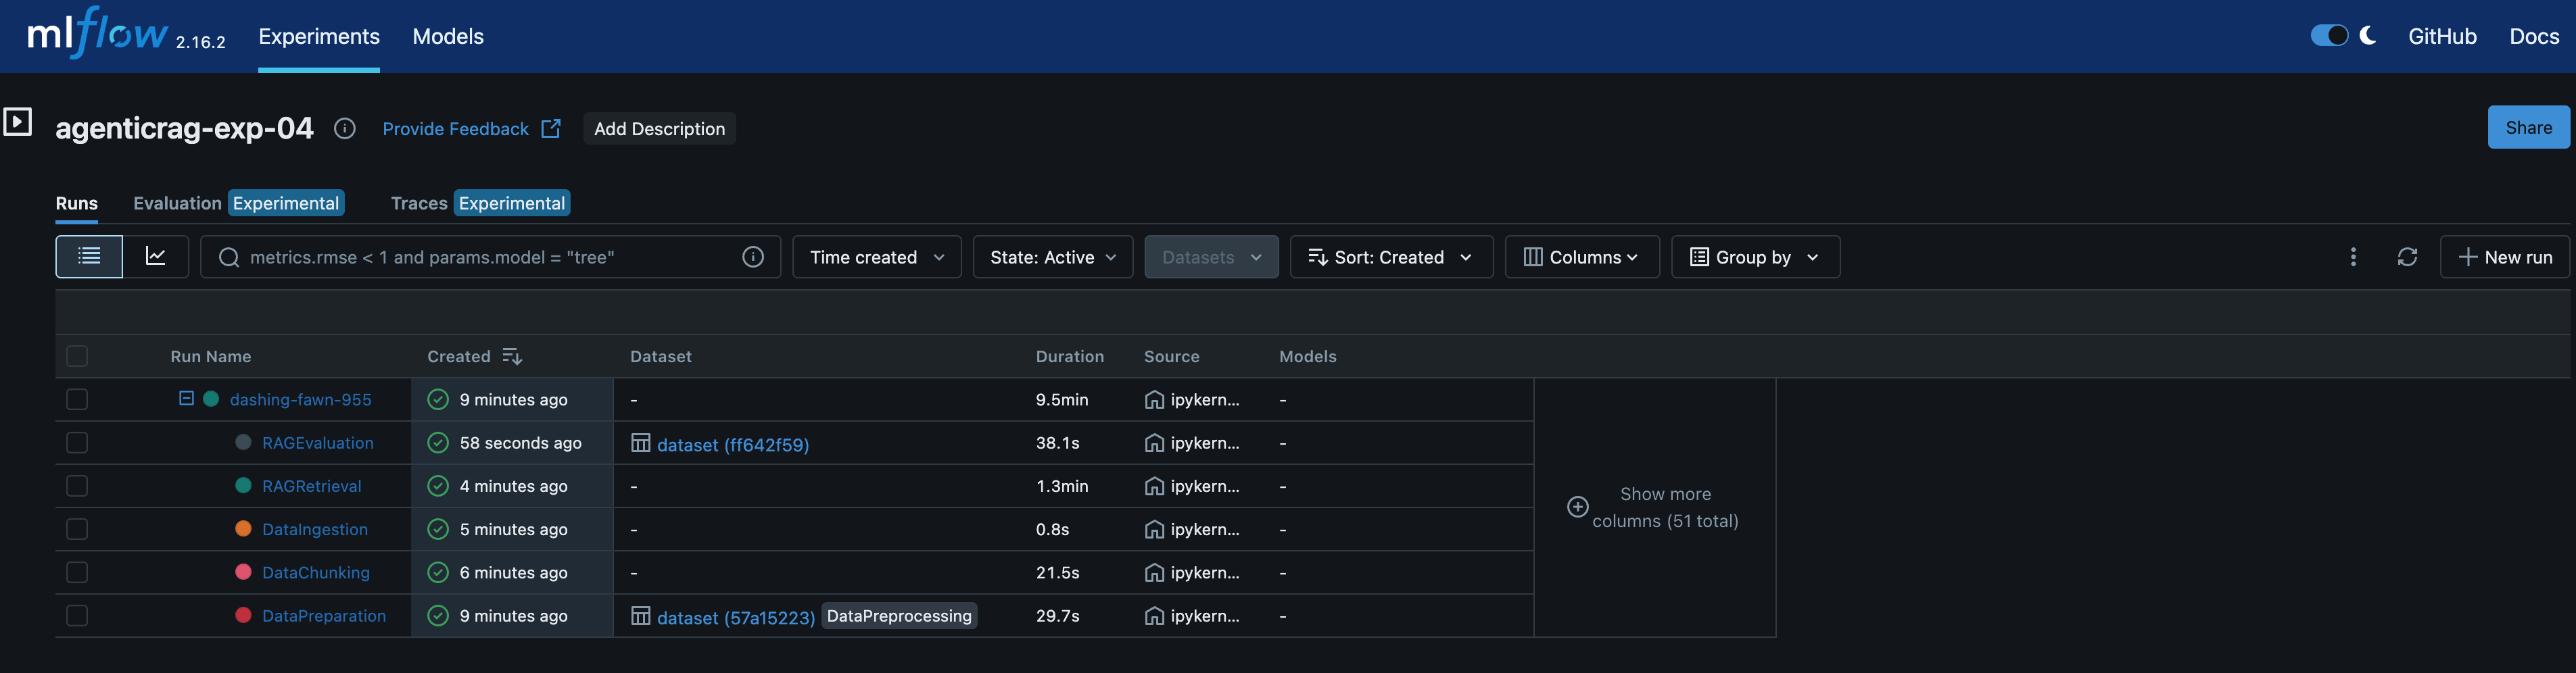

## Pre-requisites
- You will run the pip install cells in your notebook to ensure all dependencies are installed
- Set up AWS credentials and permissions if not already configured in your SageMaker environment


## WARNING: ENSURE MLFLOW VERSION IS SET TO 2.22.1 TO NOT RUN INTO COMPATIBILITY ISSUES WITH SAGEMAKER MANAGED MLFLOW

In [ ]:
%pip install sagemaker==2.237.1 --upgrade --quiet
%pip install sagemaker-mlflow mlflow==2.22.1 --quiet
%pip install datasets --upgrade --quiet
%pip install opensearch-py requests-aws4auth certifi --upgrade --quiet
%pip install datasets huggingface_hub --upgrade --quiet
%pip install langchain-text-splitters --upgrade --quiet 
%pip install langgraph --upgrade --quiet

### Pre-req step 1: Add the appropriate permissions to the SageMaker execution role

In [ ]:
import sagemaker
import utils
print(sagemaker.get_execution_role())

#### Instructions

1. Run the previous cell to get the execution role name of the notebook
2. Navigate to the IAM page, and find the corresponding role.
3. Click on 'Add Permissions' -> Create inline policy
4. On Policy editor tab on the right, click on 'JSON'
5. Paste the follow JSON into the box, replacing everything that's already in the box:

In [ ]:
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "MLFlowPermissions",
            "Effect": "Allow",
            "Action": [
                "sagemaker-mlflow:*"
            ],
            "Resource": [
                "*"
            ]
        },
        {
            "Sid": "S3FullAccess",
            "Effect": "Allow",
            "Action": [
                "s3:*"
            ],
            "Resource": [
                "*"
            ]
        }
    ]
}

### Pre-req step 1-2 : Add assume role permission to the SageMaker execution role

In order to allow the MLFlow role to make Bedrock LLM calls for RAG evaluation, allow the exeuction role to assume itself.

#### Instructions
1. In the cell below, paste in your role ARN to the "AWS" field, where it is commented.
2. Copy the JSON 
3. Navigate to the IAM page and fine the corresponding role.
4. Click on the 'Trust relationships' tab
5. Click 'Edit trust policy'
6. Replace the JSON with the JSON from the next cell.

In [ ]:
{
	"Version": "2012-10-17",
	"Statement": [
		{
			"Effect": "Allow",
			"Principal": {
				"Service": "sagemaker.amazonaws.com"
			},
			"Action": "sts:AssumeRole"
		},
		{
			"Effect": "Allow",
			"Principal": {
				"AWS": "" #REPLACE WITH YOUR EXECUTION ROLE ARN FROM ABOVE CELL
			},
			"Action": "sts:AssumeRole"
		}
	]
}

### Pre-req step 2: Enable Bedrock Model For Evaluation

#### Instructions
1. Navigate to the Amazon Bedrock AWS console.
2. On the left side navigation pane, scroll down and find 'Bedrock Configurations' -> 'Model Access'.
3. Click on 'Enable all models' and click confirm.

### Pre-req step 3: Create MLFlow Tracking Server

In [ ]:
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()
print(f"s3://{default_bucket}/mlflow")

#### Instructions:

If you already have an MLFlow Tracking Server created in your SageMaker studio, you DO NOT have to follow the steps. Just retrieve the ARN of the MLFlow server and edit the variable in the next cell.

Otherwise, follow these steps:
1. Run the previous cell to retrieve the uri Default bucket of the studio and copy to clipboard.
2. Navigate to the SageMaker Studio page and click on MLFlow in the Applications tab on the left
3. On the right side, click on 'Create'
4. Input the name for your MLFlow server, and paste the default buck uri you copied from the next cell into the 'Artifact storage location'
5. Once the MLFlow server is created, retrieve the ARN of the server from the Studio MLFlow page, and replace the next cell with the ARN.


In [ ]:
_MLFLOW_URI = "" #REPLACE WITH YOUR MLFLOW TRACKING SERVER ARN

In [ ]:
import mlflow
print(mlflow.__version__)

### Pre-req step 4: Create an OpenSearch domain 

#### Instructions

If you already have an OpenSearch domain in the region of your SageMaker Studio, you DO NOT have to follow the steps. Just retrieve the endpoint URI. 

Otherwise, follow the steps to create your opensearch domain:

1. Navigate to IAM again and fine the SageMaker execution role from previous step.
2. Click on 'Add Permissions' -> 'Attach Policies'
3. Search for 'AmazonOpenSearchServiceFullAccess' and add to the role.
4. Run the next cell to create your opensearch domain. It will take up to 15-20 minutes for it to be created. You can check the status of the domain being created by running the cell following the domain creation cell. 

In [ ]:
# Create the domain
domain_name = "rag-poc-domain" 
domain = utils.create_opensearch_domain(domain_name)

In [ ]:
# Run this cell to check the status of the domain and retrieve information like Endpoint URI
oss_info = utils.get_domain_status(domain_name)

### Pre-req step 5: Create SageMaker Endpoints for Text embedding and text generation models (Optional)

#### You can skip this step if you already have SageMaker endpoints for a text embedding model and a text generation model.

In order to create the RAG workflow, we will deploy 2 models, a text embedding model and a text generation model. 

You may choose to deploy your own model through SageMaker Studio, or run the following cells to deploy 2 endpoints.

We will be deploying the models from jumpstart, replace the model_id parameters below if you'd like to use different jumpstart models.

#### WARNING: YOU MAY NEED TO INCREASE SAGEMAKER SERVICE QUOTA FOR 'ml.g6.12xlarge for endpoint usage' IN ORDER TO DEPLOY THE TEXT GENERATION MODEL

In [ ]:
# 1. Deploy a Text Embedding Model
embedding_model_id = "huggingface-textembedding-all-MiniLM-L6-v2"
EMBEDDING_ENDPOINT_NAME= "rag-embeddings-endpoint"
embedding_instance_type = "ml.g5.xlarge" 

# 2. Deploy a Text Generation Model
text_model_id = "deepseek-llm-r1-distill-qwen-7b" 
TEXT_GENERATION_ENDPOINT_NAME = "rag-generation-endpoint"
text_gen_instance_type = "ml.g6.12xlarge"  

In [ ]:

# Create both endpoints
print("Creating embedding model endpoint...")
embedding_endpoint = utils.deploy_jumpstart_model(
    model_id=embedding_model_id, 
    endpoint_name_base=EMBEDDING_ENDPOINT_NAME,
    instance_type=embedding_instance_type
)

print("\nCreating text generation model endpoint...")
text_gen_endpoint = utils.deploy_jumpstart_model(
    model_id=text_model_id, 
    endpoint_name_base=TEXT_GENERATION_ENDPOINT_NAME,
    instance_type=text_gen_instance_type
)



In [ ]:
#Get information about the deployed endpoints

print("\n=== Deployed Endpoints ===")
print(f"Embedding Endpoint: {embedding_endpoint}")
print(f"Text Generation Endpoint: {text_gen_endpoint}")

# Wait for endpoints to be in service if needed
endpoints_to_check = [embedding_endpoint, text_gen_endpoint]
for endpoint in endpoints_to_check:
    status = utils.check_endpoint_status(endpoint)
    if status != "InService":
        print(f"Waiting for endpoint {endpoint} to be ready...")

## SagemakerAI MLFlow
We will configure MLflow integration with Amazon SageMaker for tracking and tracing agent-based workflows. Frist we establishes a connection to a specific SageMakerAI MLflow Tracking Server using an ARN (Amazon Resource Name). 
The `mlflow.set_tracking_uri()` method directs all subsequent MLflow logging operations to this server, ensuring experiment metadata is stored in the secure backend maintained by SageMaker.

(Optional) You can organize all your MLFlow observibility data by setting `mlflow.set_experiment("<YOUR_MLFLOW_EXPERIMENT_NAME>")`. Using which MLflow allows you to group runs under experiments, which can be useful for comparing runs intended to tackle a particular task.

In [ ]:
import mlflow
from mlflow.entities import SpanType
from time import gmtime, strftime
import numpy as np 
from collections import Counter

mlflow.set_tracking_uri(_MLFLOW_URI)
experiment_suffix = strftime('%d', gmtime())
experiment_name = f"RAGops-experiment-{experiment_suffix}"
experiment = mlflow.set_experiment(experiment_name=experiment_name)

# Data preparation

In this section, you will prepare your dataset for use in the Retrieval-Augmented Generation (RAG) pipeline. Data preparation is a foundational step that ensures your data is clean, well-understood, and ready for downstream tasks like embedding generation and retrieval.
- You will load a medical question-answering dataset from the Hugging Face Hub, specifically the PubMedQA artificial subset. 
- Metadata about the dataset—such as its type, source, and classification—will be logged to MLflow.
- Dataset Lineage: The dataset will be registered with MLflow, allowing you to track it and ensure that every experiment run is traceable back to the exact data version used.
- Capture statistics and other artifacts: Help with governance and understanding of your data and supports documentation and reporting.

Begin experiment tracking by starting an MLflow run. Use a nested run for data preparation to keep your workflow organized

In [ ]:
with mlflow.start_run(run_name="RAG-OPs") as run:
    main_run_id = run.info.run_id
    print("mlflow_run", main_run_id)
    with mlflow.start_run(run_name="DataPreparation", nested=True):
        mlflow.log_param("data_type", "medical")
        mlflow.log_param("data_pii", "False")
        # Public, Internal, Confidential, Restricted/Highly Confidential
        mlflow.log_param("data_classification", "Public")
        mlflow.log_param("data_source", " HuggingFace Hub")
        
        # Load your dataset from the Hugging Face Hub and log its metadata.
        from datasets import load_dataset
        data_path = "qiaojin/PubMedQA"
        data_name = "pqa_artificial"
        mlflow.log_param("data_path", data_path)
        mlflow.log_param("data_name", data_name)
        source_dataset = load_dataset(data_path, data_name)
        
        # Dataset Lineage Tracking
        # Convert to MLflow Dataset format. Also supports mlflow.data.from_dataframe
        hf_dataset = mlflow.data.from_pandas(
            df=source_dataset['train'].to_pandas(),
            )
        mlflow.log_input(
            hf_dataset, 
            context="DataPreprocessing",
            tags={
                "task": "medical_qa",
                "split": "train",
                "version": "1.0.0"
            })
        
        # dataset stats calculation 
        stats = {}
        # Basic Composition
        stats['total_entries'] = len(source_dataset['train'])
        stats['unique_questions'] = len(set(source_dataset['train']["question"]))
        
        # context Quality Analysis
        context_lengths = [len(str(context).split()) 
                           for item in source_dataset['train']["context"]
                           for context in item['contexts']] 
        stats.update({
            'avg_context_length': np.mean(context_lengths),
        })
        
        # Decision Type Distribution
        decisions = Counter(source_dataset['train']["final_decision"])
        stats.update({
            'yes_decisions': decisions.get('yes', 0),
            'no_decisions': decisions.get('no', 0),
            'maybe_decisions': decisions.get('maybe', 0)
        })
        print("stats:", stats)
        mlflow.log_metrics({
            "total_qa_pairs": stats['total_entries'],
            "unique_questions": stats['unique_questions'],
            "avg_context_length": stats['avg_context_length'],
            "decision_yes": stats['yes_decisions'],
            "decision_no": stats['no_decisions'],
            "decision_maybe": stats['maybe_decisions']
        })
        
        # Log distribution artifacts
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(10,6))
        plt.hist([len(str(c).split()) for c in source_dataset['train']["context"]], bins=50)
        plt.title("Context Length Distribution")
        plt.savefig("context_len_dist.png")
        mlflow.log_artifact("context_len_dist.png")
            

Open the new MLFLow experiment and you will see the "DataPreparation" run nested under the parent run.

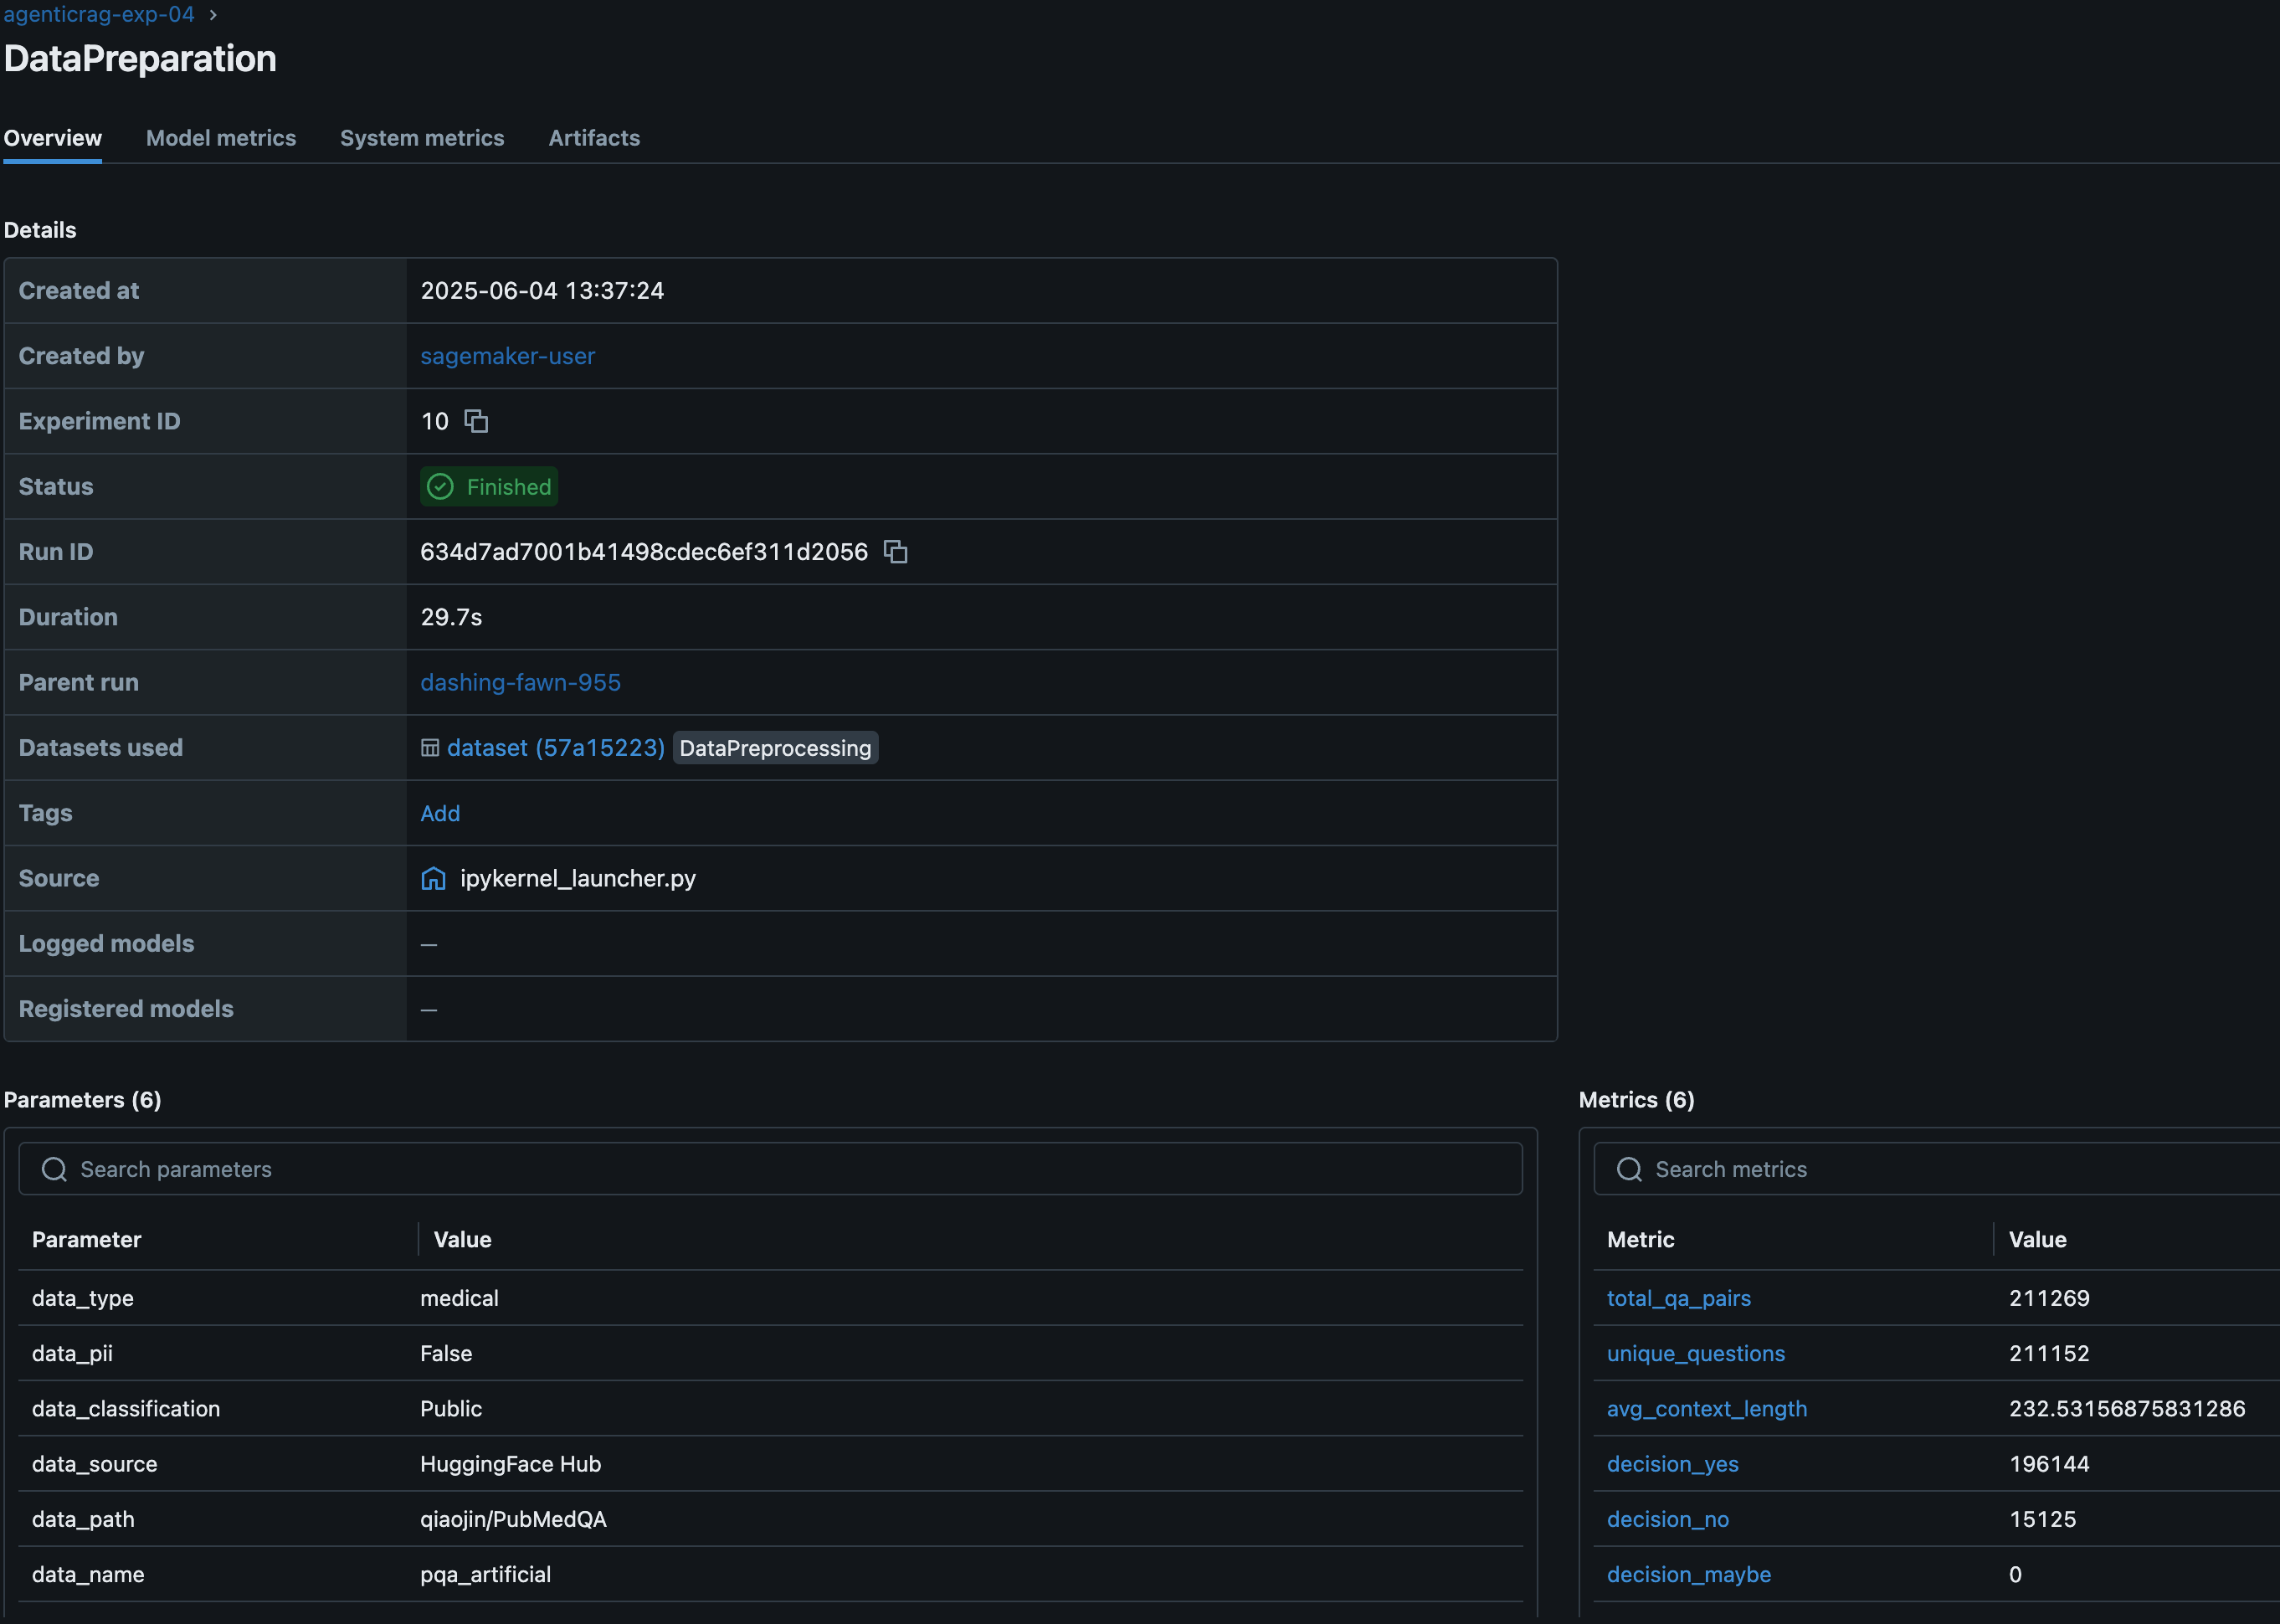

# Data chunking

In this section, you will transform your raw document contexts into smaller, manageable chunks that are suitable for embedding and retrieval. Chunking is essential for RAG pipelines because it improves retrieval accuracy, allows for more focused embeddings, and enables the model to handle long documents efficiently.

Chunking Strategy Selection:
You will choose between two chunking strategies:

FixedSizeChunker: Splits text into fixed-size chunks with overlap, ensuring each chunk is of a specified length.

RecursiveChunker: Splits text recursively, respecting logical boundaries (like paragraphs and sentences), and ensures chunks are of a specified size.

In [ ]:
from typing import List, Dict
from langchain_text_splitters.character import CharacterTextSplitter
from langchain_text_splitters import RecursiveCharacterTextSplitter

class FixedSizeChunker:
    """
    A class that divides a given text into chunks of fixed size with overlap.
    This class uses the `CharacterTextSplitter` to split text at paragraph boundaries, ensuring that
    each chunk has the specified size and overlap.

    Attributes:
        chunk_size (int): The desired size of each chunk (default is 1000 characters).
        chunk_overlap (int): The number of characters to overlap between consecutive chunks (default is 200).
        text_splitter (CharacterTextSplitter): An instance of the CharacterTextSplitter to handle the splitting process.
    """

    def __init__(self, chunk_size: int = 600, chunk_overlap: int = 300):

        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap

        self.text_splitter = CharacterTextSplitter(
            separator=".",
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            length_function=len,
            is_separator_regex=False,
            keep_separator=True,
        )

    def chunk(self, texts: list) -> List[Dict[str, str]]:
        chunks = self.text_splitter.create_documents(texts)

        return [{"chunk_text": chunk.page_content} for chunk in chunks]

class RecursiveChunker:
    """
    A class that divides a given text into chunks using recursive splitting, 
    with the specified size and overlap between chunks. This class uses the 
    `RecursiveCharacterTextSplitter` to break down the text recursively, ensuring 
    that the chunk sizes are respected while splitting at logical points.

    Attributes:
        chunk_size (int): The desired size of each chunk (default is 4000 characters).
        chunk_overlap (int): The number of characters to overlap between consecutive chunks (default is 200).
        text_splitter (RecursiveCharacterTextSplitter): An instance of the RecursiveCharacterTextSplitter to handle the splitting process.
    """

    def __init__(self, chunk_size: int = 600, chunk_overlap: int = 300):

        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap

        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            length_function=len,
            separators=["\n\n", "\n", "."],  # Initial splitting: paragraphs-> lines -> line
            keep_separator=True,  
            is_separator_regex=False,
        )

    def chunk(self, texts: list) -> List[Dict[str, str]]:
        chunks = self.text_splitter.create_documents(texts)


        return [{"chunk_text": chunk.page_content} for chunk in chunks]


#### Select chunking strategy: "RecursiveChunker" (Default) OR "FixedSizeChunker"
Choose your preferred chunking strategy and set the chunk size and overlap parameters.

In [ ]:
chunking_strategy = "RecursiveChunker" 
chunking_strategy_chunk_size = 500
chunking_strategy_chunk_overlap = 200

Begin a nested MLflow run to track the chunking process, logging the strategy and parameters.

In [ ]:
with mlflow.start_run(run_id=main_run_id) as run:
    run_id = run.info.run_id
    print("mlflow_run", run_id)
    # dataset stats calculation 
    chunking_stage_stats = {}
    with mlflow.start_run(run_name="DataChunking", nested=True):
        mlflow.log_param("chunking_strategy_type", chunking_strategy)
        mlflow.log_param("chunking_strategy_chunk_size", chunking_strategy_chunk_size)
        mlflow.log_param("chunking_strategy_chunk_overlap", chunking_strategy_chunk_overlap)
        
        source_contexts = source_dataset['train']['context']
        
        if chunking_strategy=="RecursiveChunker":
            chunker = RecursiveChunker(chunk_size=chunking_strategy_chunk_size, chunk_overlap=chunking_strategy_chunk_overlap)
        elif chunking_strategy=="FixedSizeChunker":
            chunker = FixedSizeChunker(chunk_size=chunking_strategy_chunk_size, chunk_overlap=chunking_strategy_chunk_overlap)
        else:
            #Default chunker
            chunker = RecursiveChunker(chunk_size=chunking_strategy_chunk_size, chunk_overlap=chunking_strategy_chunk_overlap)
        
        source_contexts_chunked_count = 0
        source_contexts_chunked = []
        for context_documents in source_contexts:
            recursive_chunker_chunks = chunker.chunk(context_documents['contexts'])
            source_contexts_chunked_count = source_contexts_chunked_count + len(recursive_chunker_chunks)
            source_contexts_chunked.extend(recursive_chunker_chunks)
 
        chunking_stage_stats['total_source_contexts_entries'] = len(source_contexts)
        chunking_stage_stats['total_contexts_chunked'] = source_contexts_chunked_count
        unique_chunks = len({tuple(chunk.items()) for chunk in source_contexts_chunked})
        chunking_stage_stats['total_unique_chunks_final'] = unique_chunks
        print(f"stats: {chunking_stage_stats}")
        mlflow.log_metrics({
            "total_source_contexts_entries": chunking_stage_stats['total_source_contexts_entries'],
            "total_contexts_chunked": chunking_stage_stats['total_contexts_chunked'],
            "total_unique_chunks_final": chunking_stage_stats['total_unique_chunks_final'],
        })       
            

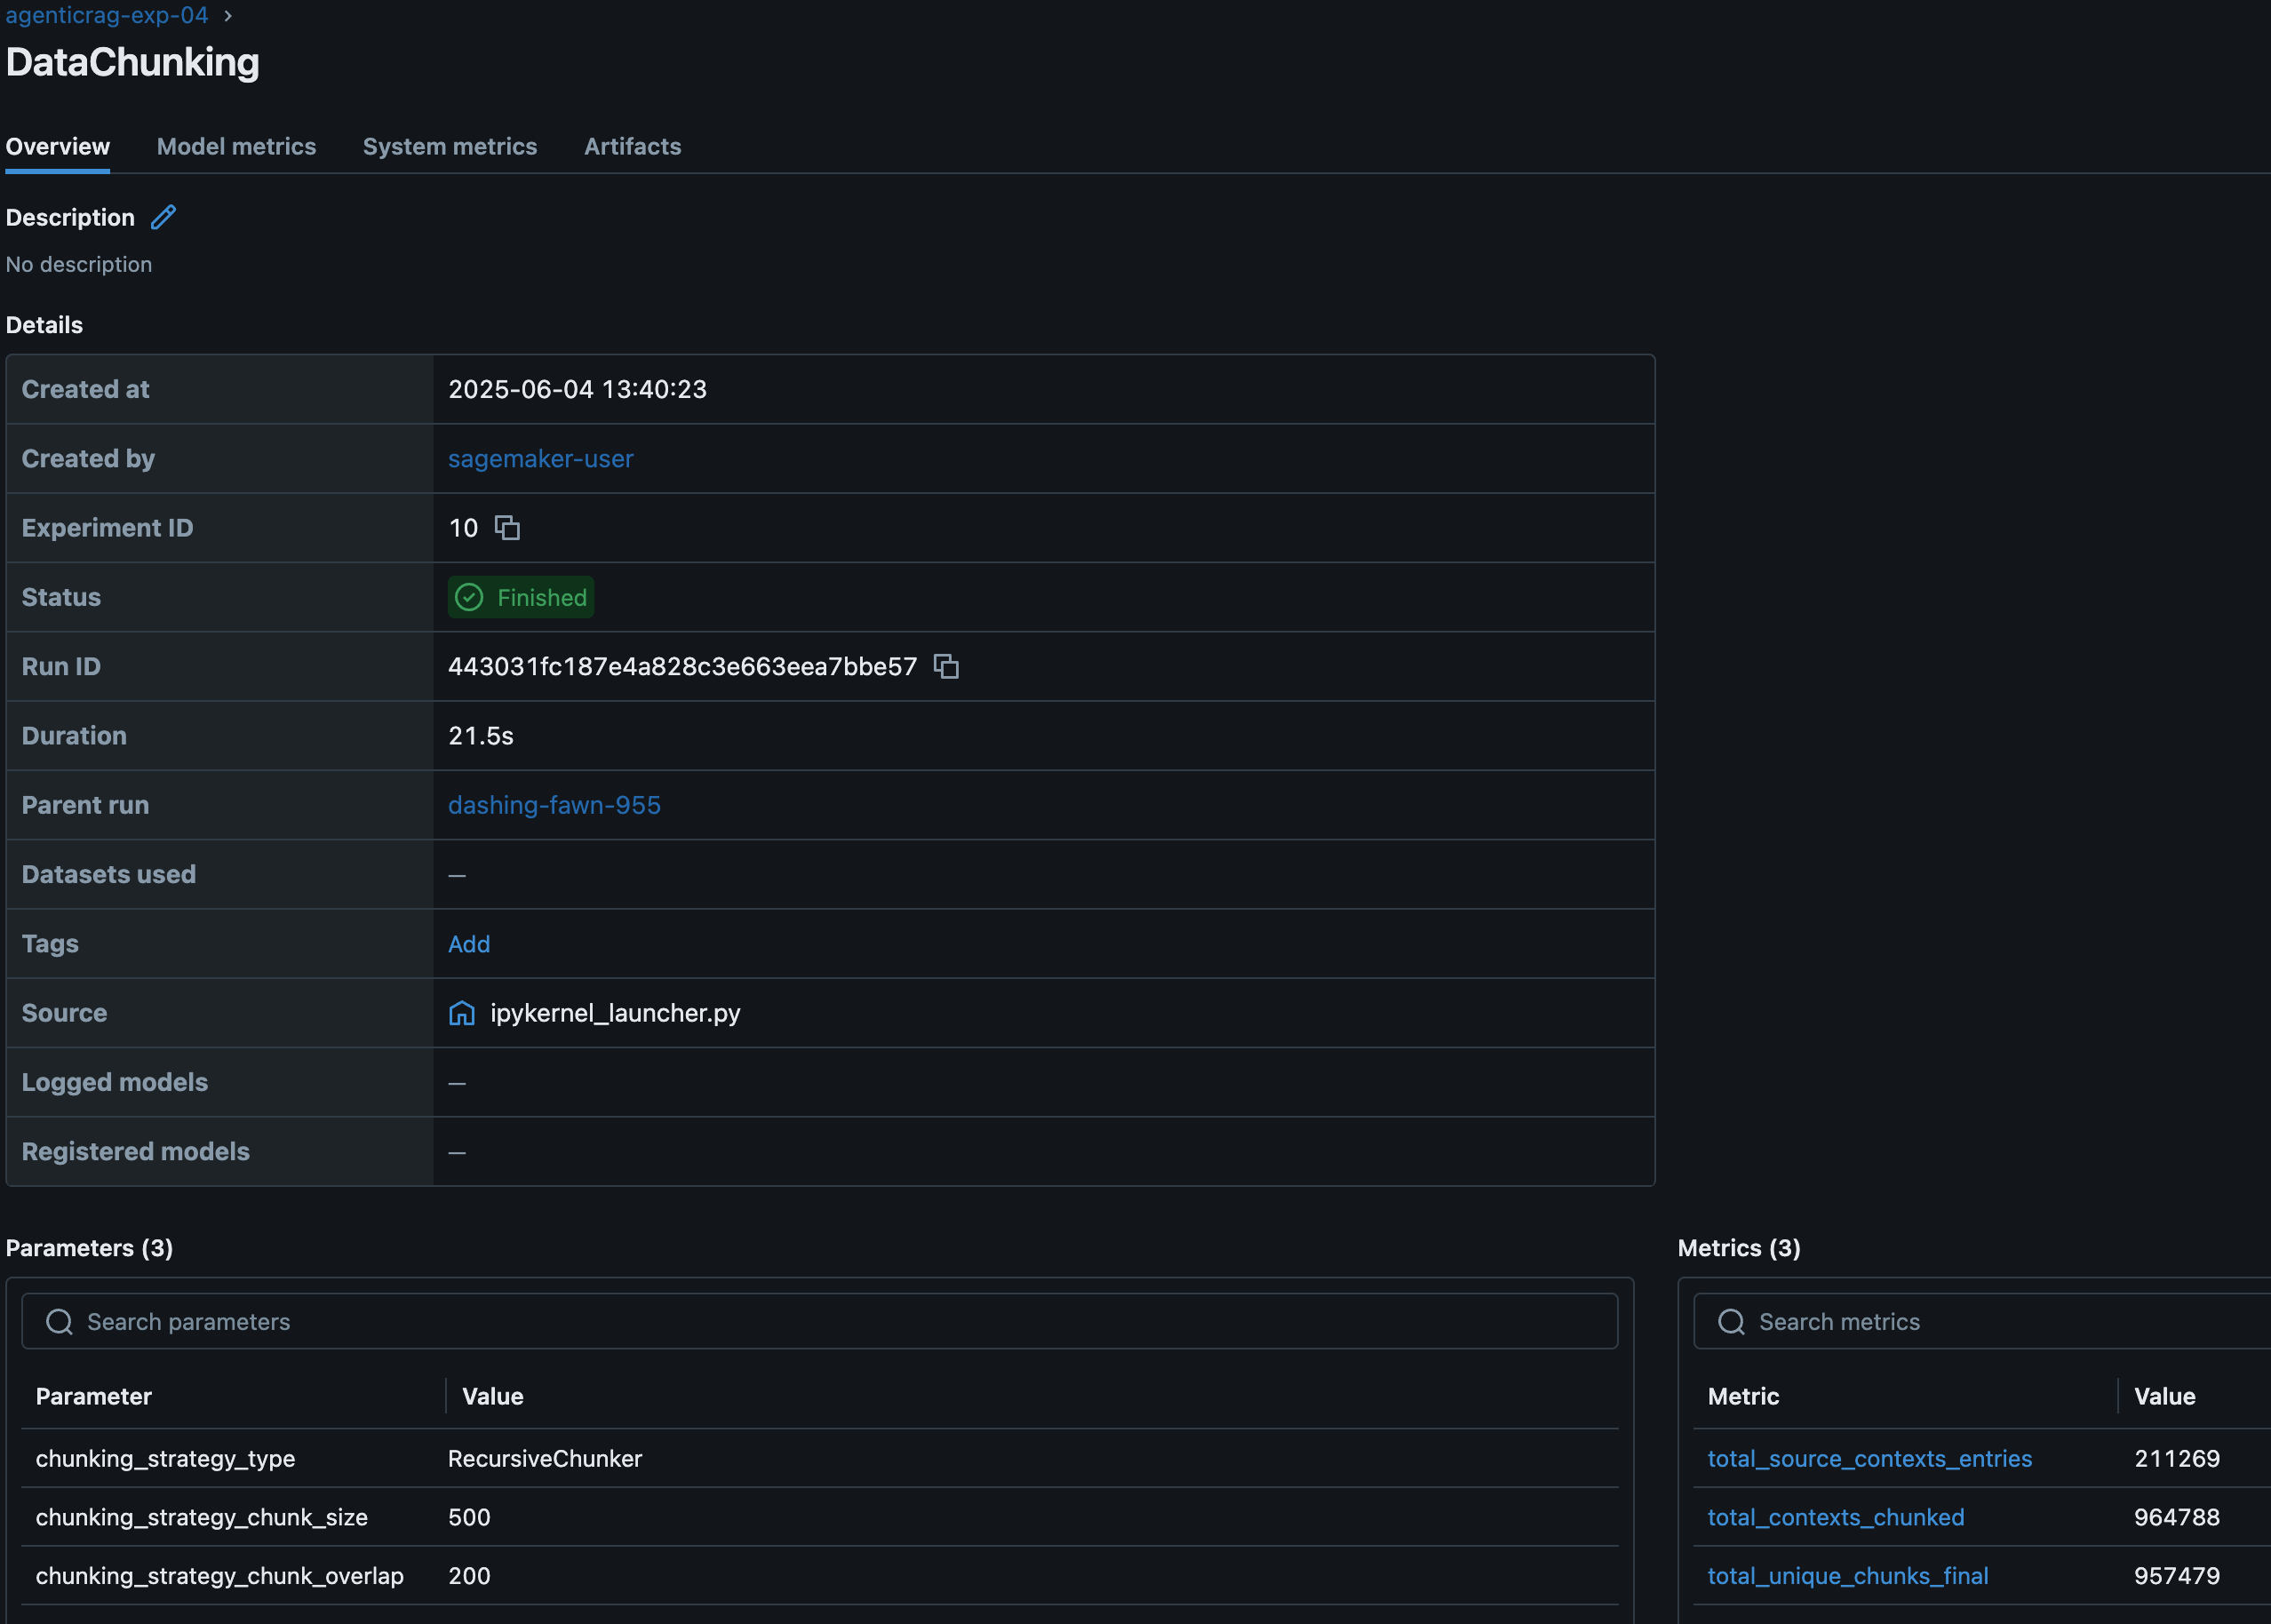

# Data Ingestion
In this section, you will prepare your vector database (AWS OpenSearch) for efficient document retrieval by ingesting your chunked documents and their embeddings. You will also configure experiment tracking with MLflow for reproducibility and collaboration.

### OpenSearch vector database 

Initialize a client to interact with your AWS OpenSearch cluster.

Instructions:

- Define your OpenSearch endpoint, port, and region.
- Set up AWS authentication using your credentials.
- Initialize the OpenSearch client.

Note: If you are bringing your own Domain, ensure to add your sagemaker role as the backend role in the opensearch domain dashboard page. (Mapping roles to users)[https://docs.aws.amazon.com/opensearch-service/latest/developerguide/fgac.html#fgac-access-control]

In [ ]:
from opensearchpy import OpenSearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth
import boto3
import os

In [ ]:
service = "es"  

# domain_name = "" # UNCOMMENT AND REPLACE WITH YOUR DOMAIN NAME IF YOUR ARE BRINGING YOUR OWN DOMAIN
oss_info = utils.get_domain_status(domain_name)
host = oss_info['Endpoint'] 

port = 443
index_name = "ragops-exp-index"
region = os.environ.get('AWS_REGION')

#### AWS Opensearch database 
Note: You will need to initialize OpenSearch client opensearch_client for all the RAG pipeline steps

In [ ]:
# Authentication setup
credentials = boto3.Session().get_credentials()
awsauth = AWS4Auth(
    credentials.access_key,
    credentials.secret_key,
    region,
    service,
    session_token=credentials.token
)

# Initialize OpenSearch client
opensearch_client = OpenSearch(
    hosts=[{'host': host, 'port': port}],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection
)

In [ ]:
# Test OpenSearch
print(opensearch_client)

# Test connection by listing indices
try:
    response = opensearch_client.indices.get_alias(index="*")
    print("Indices:", response)
except Exception as e:
    print("Error connecting to OpenSearch:", str(e))

# Test index
print(opensearch_client.indices.exists(index=index_name))

Create an OpenSearch index with knn_vector support for storing document text and embeddings.
Set the embedding dimension to match your embedding model (e.g., 384 for the huggingface-textembedding-all-MiniLM-L6-v2 model used here).

In [ ]:
# Create openseaerch vector index with knn support
index_body = {
    "settings": {
        "index.knn": True,
        "number_of_shards": 1,
        "number_of_replicas": 2
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "vector": {
                "type": "knn_vector",
                "dimension": 384  # Change to match embedding model dimension
            }
        }
    }
}


In [ ]:
# Prepare to generate embeddings for your document chunks using a SageMaker endpoint.
from sagemaker.serializers import JSONSerializer, IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor

embedding_model_predictor = Predictor(
    endpoint_name=EMBEDDING_ENDPOINT_NAME,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

Document ingestion function to Ingest Documents into OpenSearch. For each document chunk, generate an embedding and store it in OpenSearch.

In [ ]:

def ingest_documents(documents):
    ingested_count = 0
    total_documents = len(documents)
    
    try:
        for doc_id, text_dict in enumerate(documents):
            embedding_response = embedding_model_predictor.predict({'inputs': text_dict["chunk_text"]})
            document = {
                "text": text_dict['chunk_text'],
                "vector": embedding_response[0]
            }
            opensearch_client.index(
                index=index_name,
                id=doc_id,
                body=document
            )
            ingested_count += 1
            print(f"ingested {ingested_count} chunks")
        
        opensearch_client.indices.refresh(index=index_name)
        
        success_message = f"Successfully ingested {ingested_count} out of {total_documents} documents."
        return {"status": "success", "message": success_message, "ingested_count": ingested_count}
    
    except Exception as e:
        error_message = f"Error occurred while ingesting documents. {ingested_count} out of {total_documents} documents were ingested before the error. Error: {str(e)}"
        return {"status": "error", "message": error_message}

### MLFlow run: DataIngestion
Track Experiment with MLflow

In [ ]:
with mlflow.start_run(run_id=main_run_id) as run:
    run_id = run.info.run_id
    print("mlflow_run", run_id)
    with mlflow.start_run(run_name="DataIngestion", nested=True):
        mlflow.log_param("database_type", "opensearch")
        mlflow.log_param("database_name", opensearch_client.transport.hosts[0]['host'])
        mlflow.log_param("database_index", index_name)
        if opensearch_client.indices.exists(index=index_name):
            mlflow.log_param("database_index_creation", "False")
        else:
            mlflow.log_param("database_index_creation", "True")
            opensearch_client.indices.create(
                index=index_name,
                body=index_body
            )
        
        mlflow.log_param("embedding_model_id", embedding_model_id)
        mlflow.log_param("text_model_id", text_model_id)
        mlflow.log_param("embedding_sagemaker_endpoint", EMBEDDING_ENDPOINT_NAME)
        mlflow.log_param("text_sagemaker_endpoint", TEXT_GENERATION_ENDPOINT_NAME)

        # Ingest context to the vector database
        #testing with only first 100 chunks to save time for testing
        result = ingest_documents(source_contexts_chunked[:100])
        mlflow.log_metric("ingested_count", result["ingested_count"])

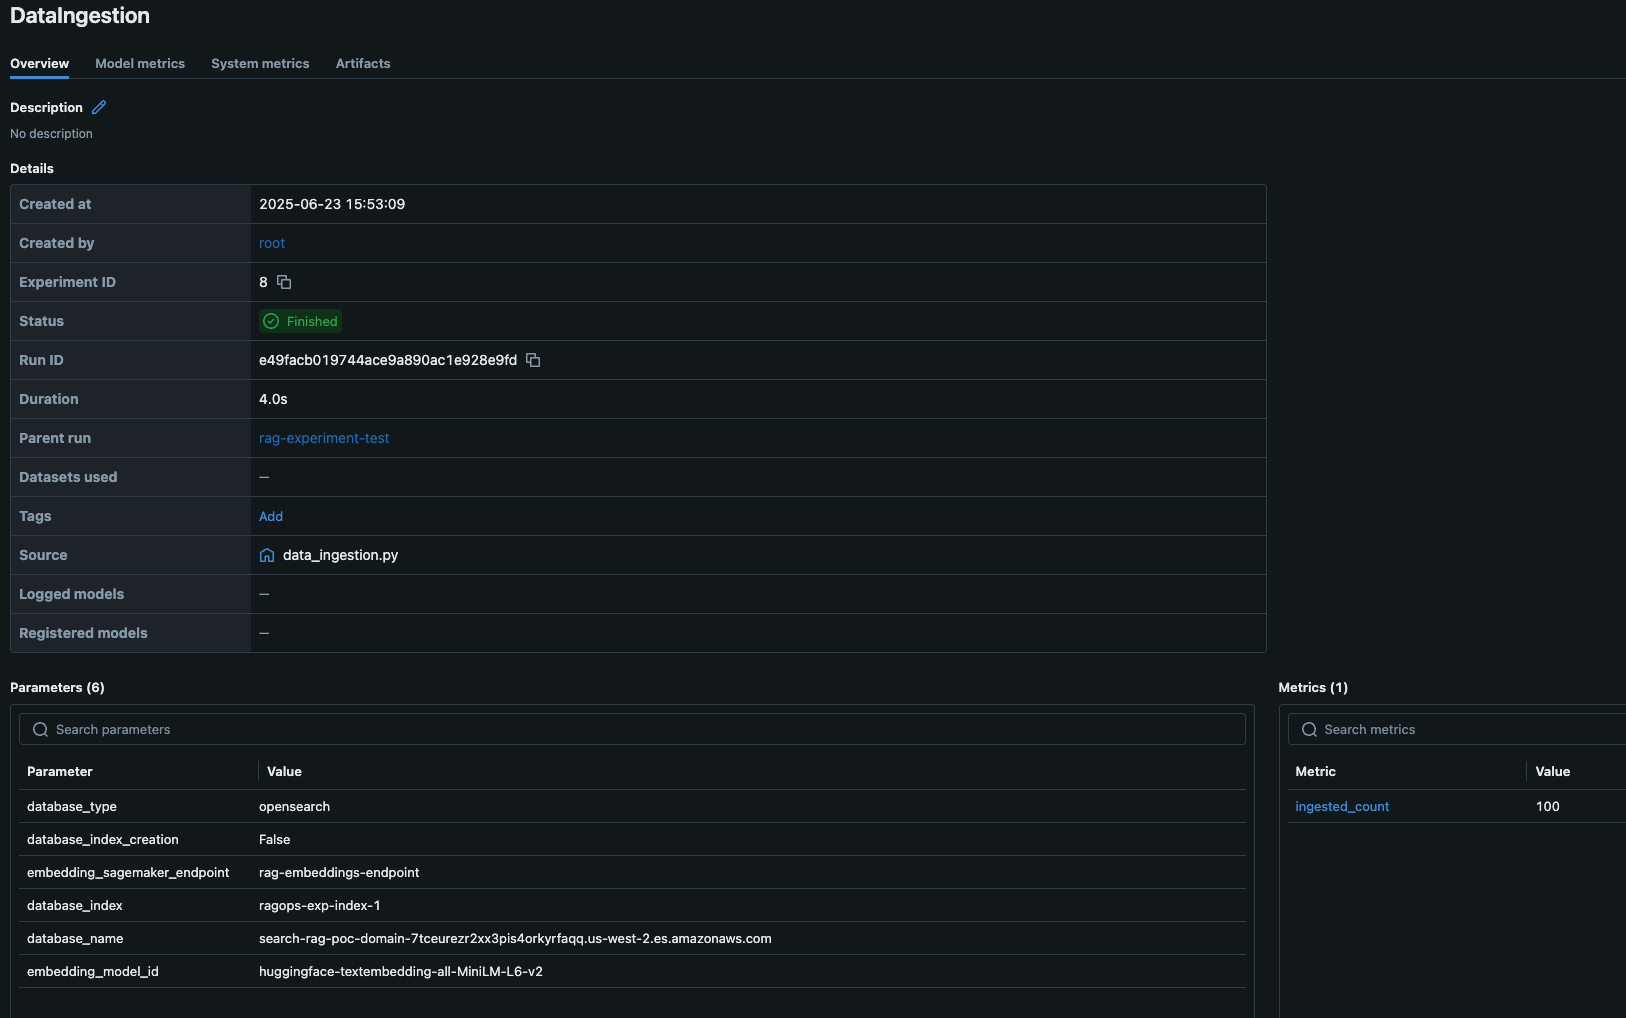

# RAG Retrieval
In this section, you will implement the core retrieval and generation logic of your Retrieval-Augmented Generation (RAG) pipeline. You will use the OpenSearch vector database for semantic document retrieval and a SageMaker LLM endpoint for text generation. The process is orchestrated with LangChain and LangGraph, and experiment tracking is managed by MLflow.

- Retrieval:
For a given query, you will generate an embedding, search the OpenSearch index for relevant documents, and return the top results.

- Generation:
You will use a SageMaker LLM endpoint to generate an answer based on the retrieved documents and the query.

- Workflow Orchestration:
You will use LangGraph to define a stateful workflow that chains retrieval and generation steps.

- Experiment Tracking:
You will log retrieval and generation parameters, metrics, and sample results to MLflow for analysis and reproducibility.

Note: Initialize OpenSearch client `opensearch_client` from the data ingestion stage if the credentials have expired.

In [ ]:
CONTEXT_RETRIEVAL_SIZE=3

Set your text generation model details and endpoint and Initialize the SageMaker predictor for text generation.

In [ ]:
from sagemaker.serializers import JSONSerializer, IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor

# Load the text generation model as a SageMaker Predictor
text_generation_predictor = Predictor(
    endpoint_name=TEXT_GENERATION_ENDPOINT_NAME,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

Retrieval Function: Implement a function to retrieve relevant documents from OpenSearch using a query embedding.

- Generate an embedding for the query using your embedding model.
- Search the OpenSearch index for the top-k documents.
- Return the retrieved document texts.

In [ ]:
# RAG retrieval function
def retrieve_context(query, k=CONTEXT_RETRIEVAL_SIZE):
    query_embedding = embedding_model_predictor.predict({'inputs': query})
    
    search_body = {
        "size": k,
        "query": {
            "knn": {
                "vector": {
                    "vector": query_embedding[0],
                    "k": k
                }
            }
        }
    }
    
    response = opensearch_client.search(
        index=index_name,
        body=search_body
    )
    
    return [hit["_source"]["text"] for hit in response["hits"]["hits"]]

In [ ]:
# enable automatic logging of traces
mlflow.langchain.autolog()

### Retrieval and summarization tool (Using Langgraph)
Define a stateful workflow using LangGraph to chain retrieval and generation steps.
- Define the application state structure.
- Implement the retrieve and generate functions.
- Build and compile the workflow graph.

In [ ]:
from langchain import hub
from langchain_core.documents import Document
from langchain_core.messages import BaseMessage
from langchain.schema import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import START, StateGraph
from typing import List, Dict, Union, Any
from typing_extensions import TypedDict

from utils import lc_to_openai_messages

#### Prompt registry
- Here we load RAG prompt from LangChain Hub
- You can replace and use prompt from promp registry of your choice

In [ ]:
prompt = hub.pull("rlm/rag-prompt")

In [ ]:


# Define application state structure
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

@mlflow.trace(attributes={"workflow": "agentrag_retrieve_node"}, span_type=SpanType.AGENT) # Controlled logging of traces (Optional)
def retrieve(state: State) -> Dict[str, List[Document]]:
    """
    Retrieves relevant documents for a given question using vector search.

    Args:
        state (State): The current state containing the question.

    Returns:
        Dict[str, List[Document]]: A dictionary with retrieved context documents.

    Raises:
        RuntimeError: If document retrieval fails.
    """
    current_span = mlflow.active_span()
    print(f"Retrieve span ID: {current_span.span_id}")
    try:
        document_chunks = retrieve_context(
            query=state["question"]
            )
        return {"context": document_chunks}
    except Exception as e:
        raise RuntimeError(f"Document retrieval failed: {e}")

@mlflow.trace(attributes={"workflow": "agentrag_generate_node"}, span_type=SpanType.AGENT)
def generate(state: State) -> Dict[str, str]:
    """
    Generates an answer using retrieved context and user question.

    Args:
        state (State): The current state containing question and context documents.

    Returns:
        Dict[str, str]: A dictionary with the generated answer.

    Raises:
        RuntimeError: If text generation fails or returns an unexpected response.
    """
    current_span = mlflow.active_span()
    print(f"Retrieve span ID: {current_span.span_id}")
    try:
        docs_content = "\n\n".join(doc for doc in state["context"])

        # Generate LangChain messages and convert to OpenAI format
        lc_messages = prompt.invoke({
            "question": state["question"],
            "context": docs_content
        }).to_messages()
        openai_messages = lc_to_openai_messages(lc_messages)

        request = {
            "messages": openai_messages,
            "temperature": 0.2,
            "max_new_tokens": 512,
        }

        response = text_generation_predictor.predict(request)

        # Validate response structure
        if ("choices" not in response 
                or not response["choices"] 
                or "message" not in response["choices"][0]
                or "content" not in response["choices"][0]["message"]):
            raise ValueError("Unexpected response format from text generation predictor.")

        return {"answer": response["choices"][0]["message"]["content"],
            "context": docs_content
               }

    except Exception as e:
        raise RuntimeError(f"Text generation failed: {e}")

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")

In [ ]:
%%time
graph_with_context = graph_builder.compile()
# Test RAG retrieval 
query = "Is tP53 Pro72 allele enriched in oral tongue cancer and frequently mutated in esophageal cancer in India?"
graph_with_context_response = graph_with_context.invoke(
    {
        "question": query
    }
    )
print(graph_with_context_response)
print(graph_with_context_response["context"])

In [ ]:
%%time
# Another Test RAG retrieval 
negative_query = "Are human enteroviruses the cause of neurological impairments in children at the Korle-Bu Teaching Hospital?"
negative_response = graph_with_context.invoke(
    {
        "question": negative_query
    }
    )
print(negative_response["answer"])

### MLFlow Run: RAGRetrieval
Track Experiment with MLflow. Log retrieval and generation parameters, metrics, and sample results to MLflow.

In [ ]:
with mlflow.start_run(run_id=main_run_id) as run:
    run_id = run.info.run_id
    print("mlflow_run", run_id)
    with mlflow.start_run(run_name="RAGRetrieval", nested=True):
        mlflow.log_param("database_type", "opensearch")
        mlflow.log_param("database_name", opensearch_client.transport.hosts[0]['host'])
        mlflow.log_param("database_index", index_name)
        mlflow.log_param("embedding_model_id", embedding_model_id)
        mlflow.log_param("text_model_id", text_model_id)
        mlflow.log_param("embedding_sagemaker_endpoint", EMBEDDING_ENDPOINT_NAME)
        mlflow.log_param("text_sagemaker_endpoint", TEXT_GENERATION_ENDPOINT_NAME)
        mlflow.log_param("RAG_context_size", CONTEXT_RETRIEVAL_SIZE)
        
        # Source test queries
        TEST_SAMPLE_SIZE = 10 # First 10 questions
        sample_questions = [q for q in source_dataset["train"]["question"][:TEST_SAMPLE_SIZE]]
        mlflow.log_metrics({
            "RAG_query_size": len(sample_questions)
        })
        # Initialize metrics collection
        retrieval_metrics = {
            "total_queries": len(sample_questions),
            "contexts_per_query": [],
            "missing_context_count": 0,
            "context_lengths": []
        }
        query_examples = []
        
        # Retrieval & summarization tool (Build Langgraph StateGraph)
        graph_with_context = graph_builder.compile()
        
        # Test retrieval for each sample question
        for idx, question in enumerate(sample_questions):
            response = graph_with_context.invoke({"question": question})
            contexts = response.get("context", [])
            
            # Collect metrics
            num_contexts = len(contexts.split('\n\n'))
            retrieval_metrics["contexts_per_query"].append(num_contexts)
            retrieval_metrics["context_lengths"].extend([len(c) for c in contexts.split('\n\n')])
            
            if num_contexts == 0:
                retrieval_metrics["missing_context_count"] += 1
            
            # Store examples for artifact logging
            query_examples.append({
                "question": question,
                "context_count": num_contexts,
                "contexts_sample": contexts  # Store first 2 contexts
            })
        
        # Calculate derived metrics
        avg_contexts = np.mean(retrieval_metrics["contexts_per_query"]) if retrieval_metrics["contexts_per_query"] else 0
        missing_context_rate = retrieval_metrics["missing_context_count"] / retrieval_metrics["total_queries"]
        avg_context_length = np.mean(retrieval_metrics["context_lengths"]) if retrieval_metrics["context_lengths"] else 0
        print(avg_contexts, missing_context_rate, avg_context_length)

        # Log metrics to MLflow
        mlflow.log_metrics({
            "avg_contexts_per_query": avg_contexts,
            "missing_context_rate": missing_context_rate,
            "avg_context_length": avg_context_length,
            "total_missing_context": retrieval_metrics["missing_context_count"]
        })
        
        # Log sample results as artifact
        import json
        with open("retrieval_samples.json", "w") as f:
            json.dump(query_examples, f, indent=2)
        mlflow.log_artifact("retrieval_samples.json")
        

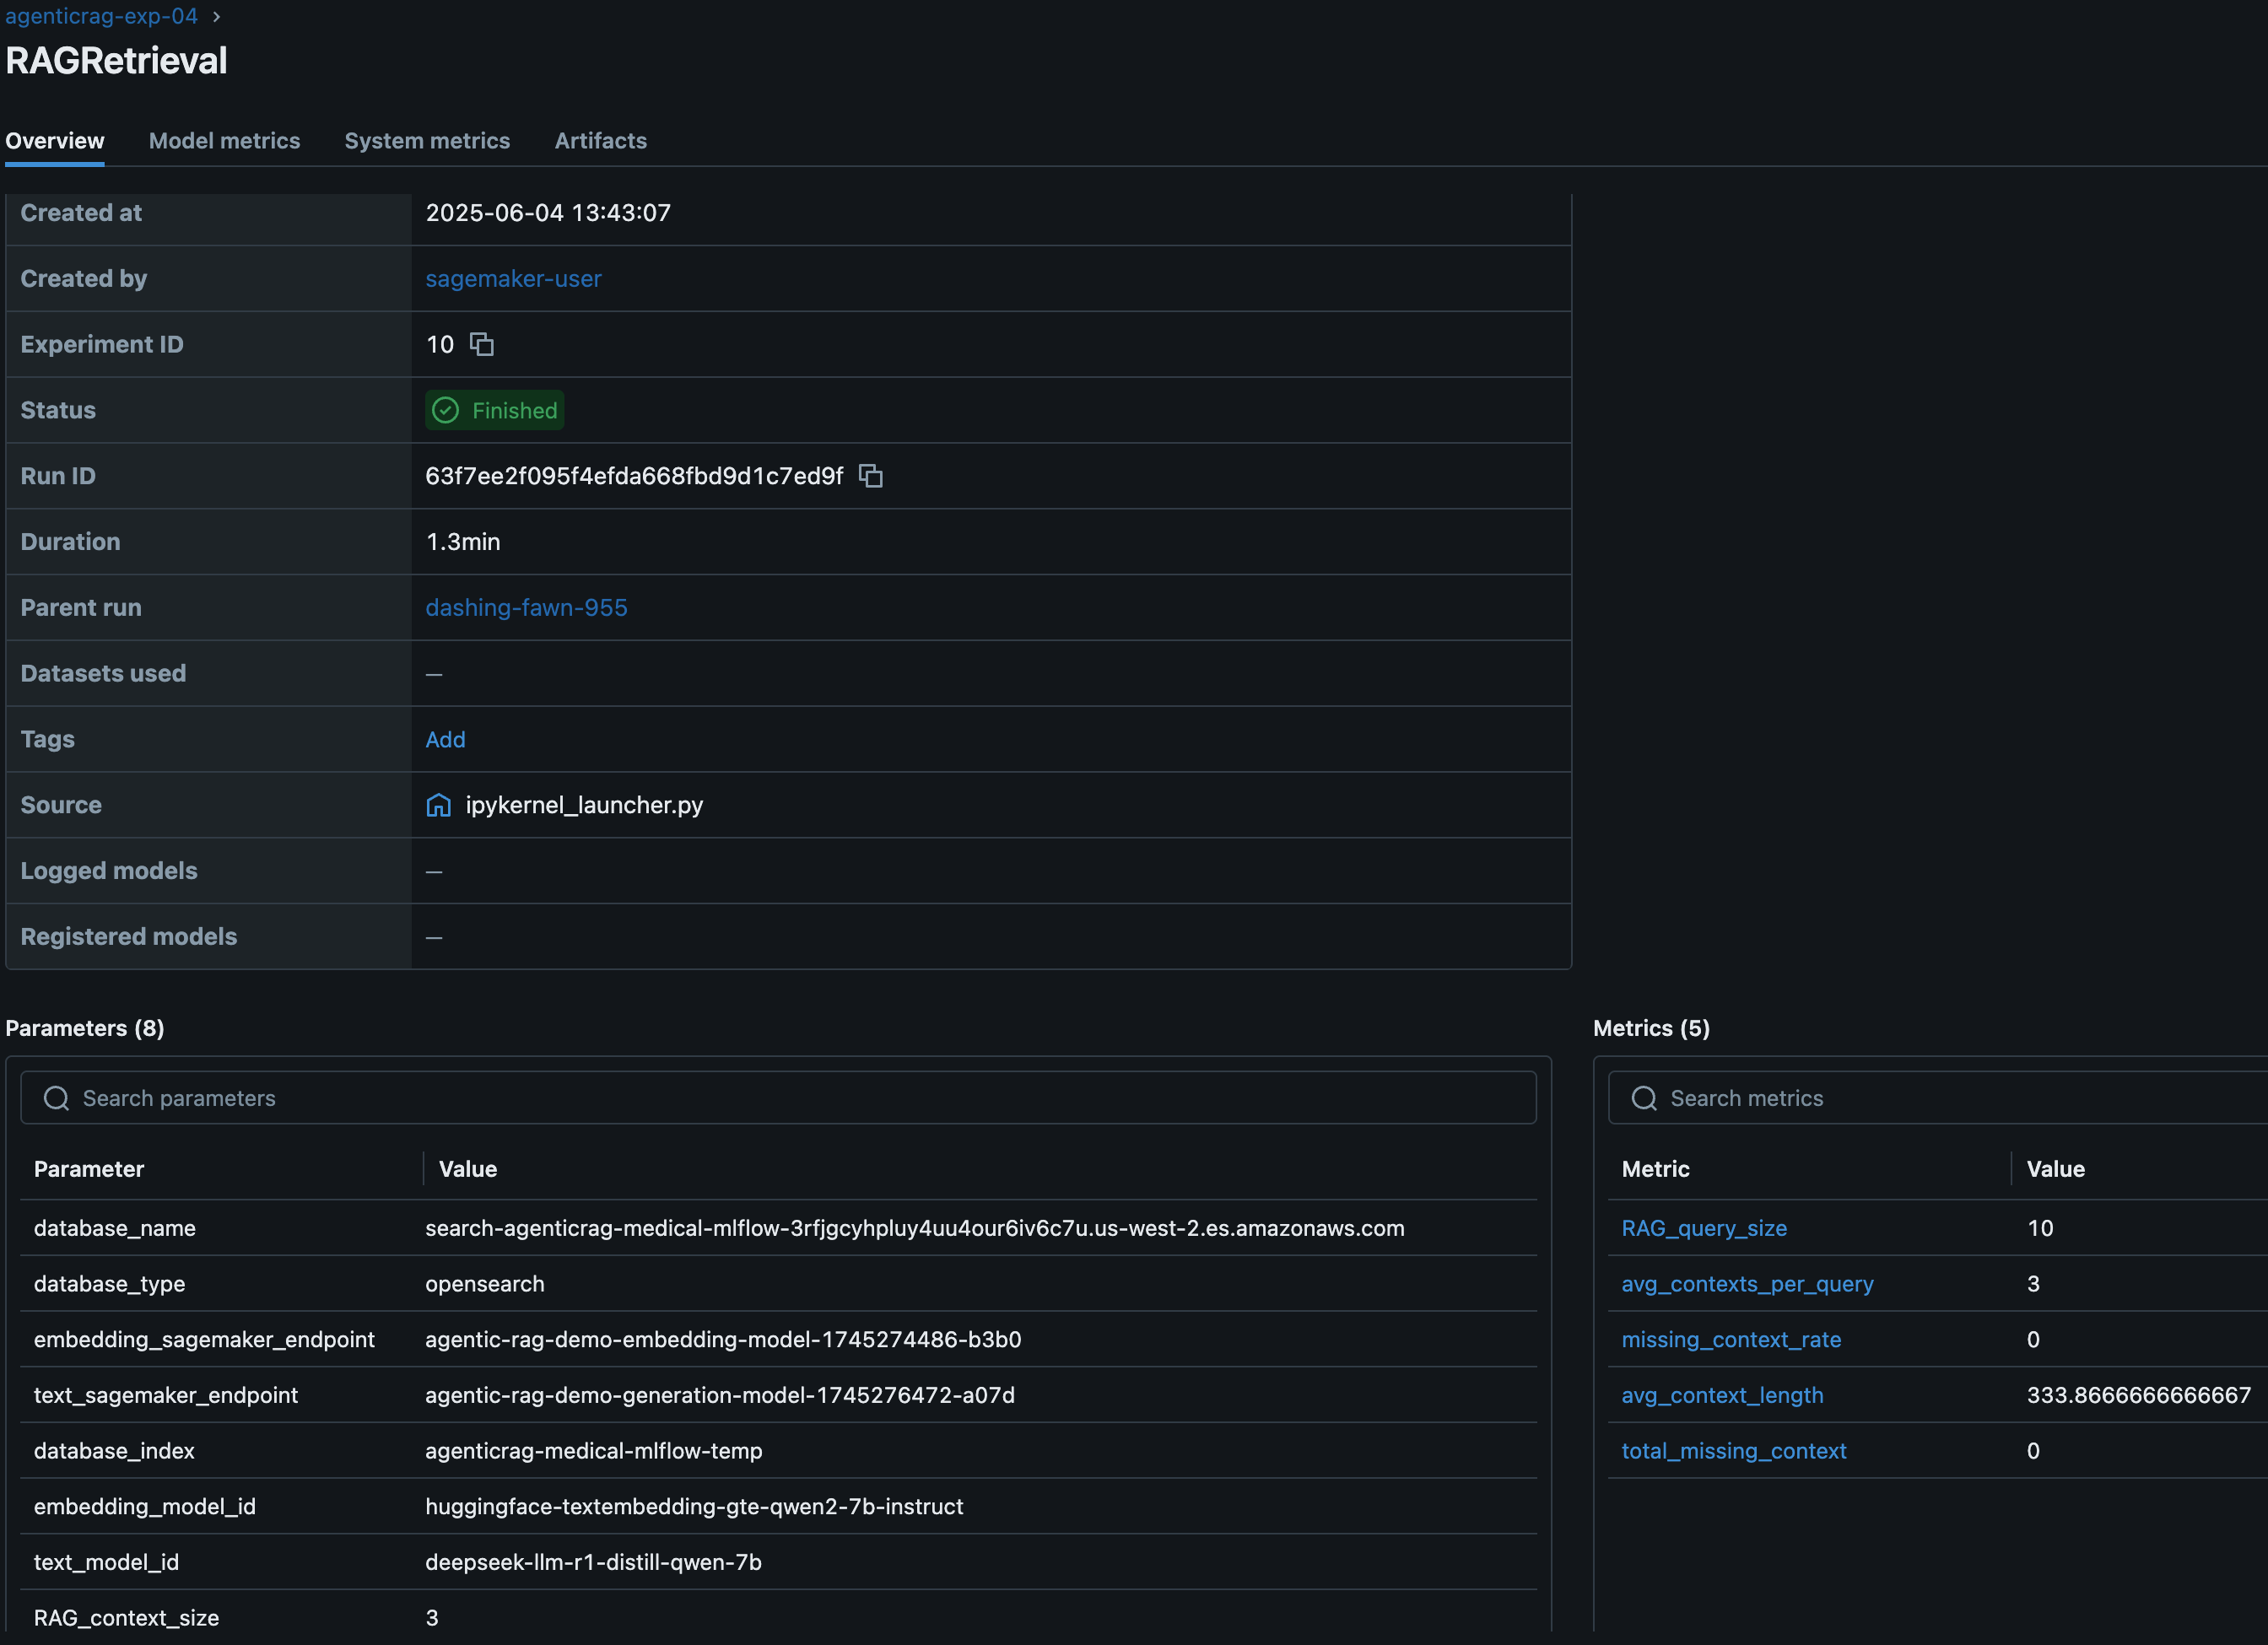

## LangGraph Traces In MLFlow

With the build-in LangGraph auto tracing, you can also see the LangGraph traces within the MLFlow console

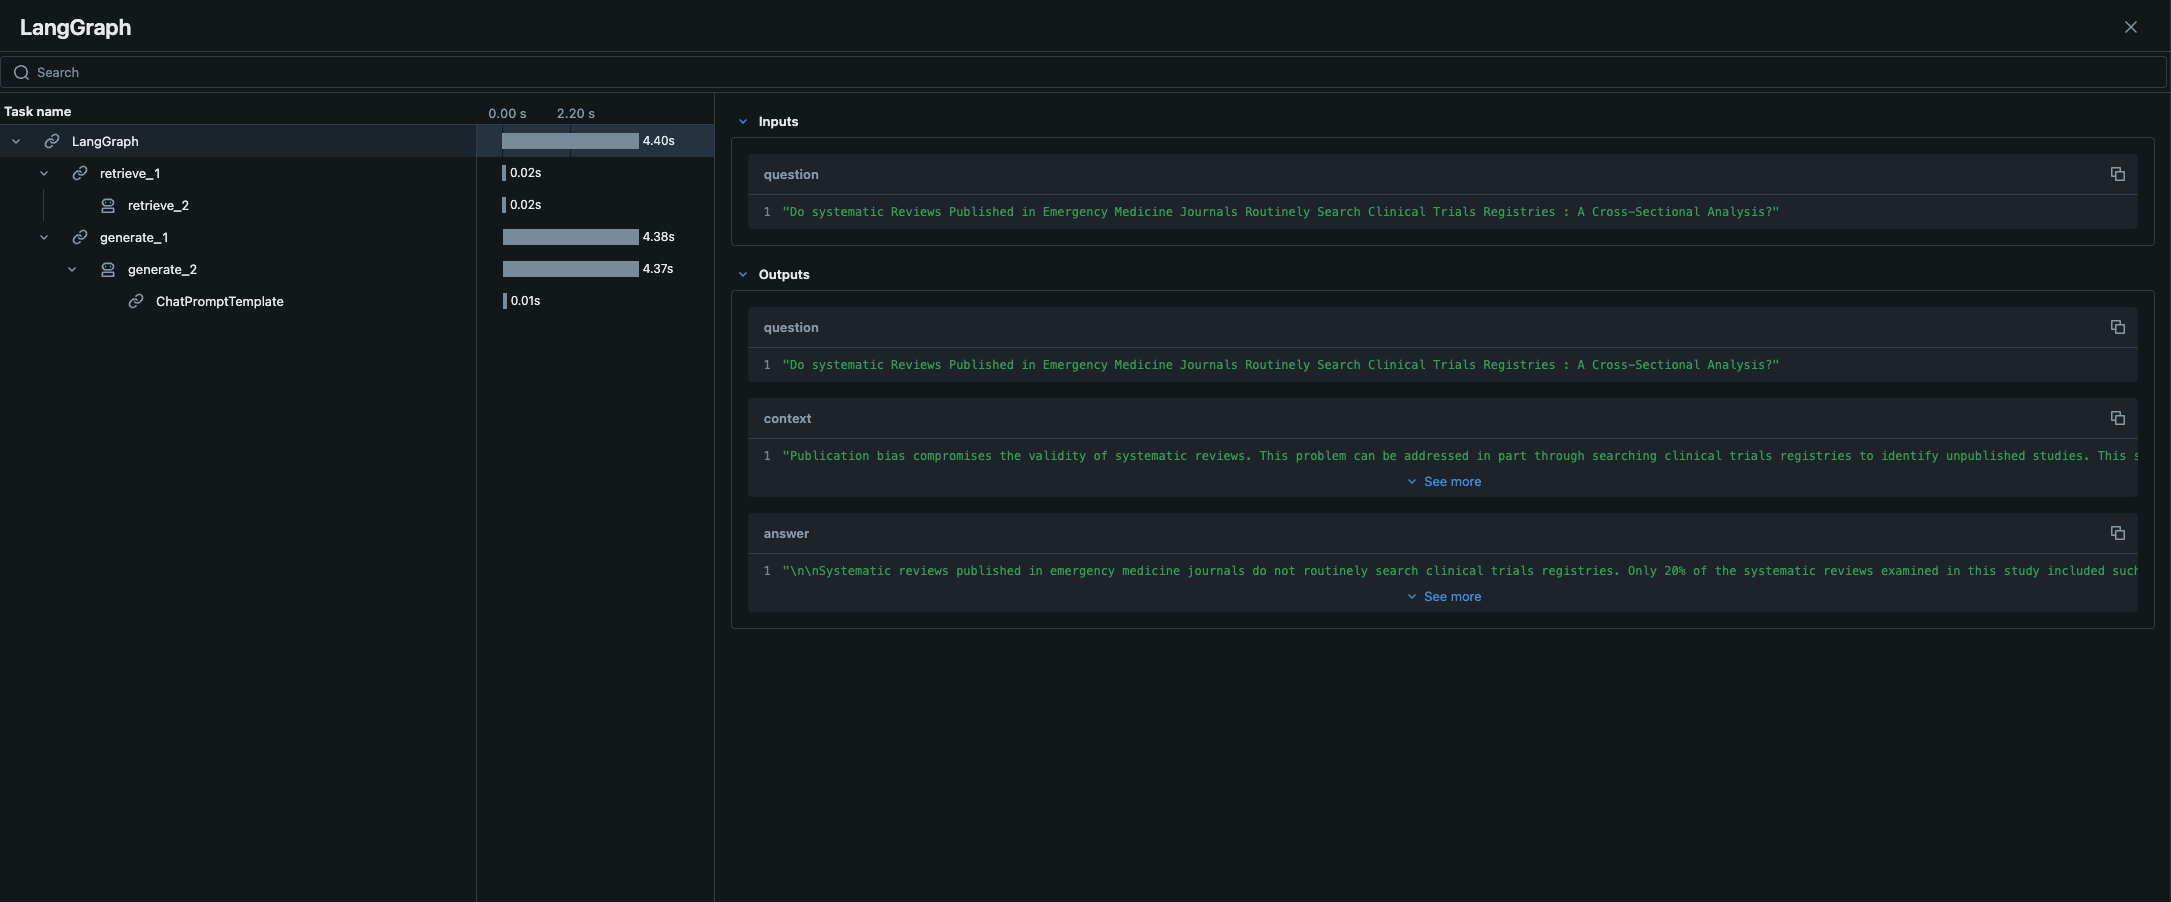

# RAG pipeline Evaluations
In this section, you will systematically evaluate your Retrieval-Augmented Generation (RAG) pipeline using a set of established metrics. You will use both traditional NLP metrics (like ROUGE and token count) and advanced GenAI evaluators (like answer correctness, similarity, relevance, and faithfulness) powered by LLMs. All evaluation results and configurations will be tracked in MLflow for reproducibility and analysis.

What is Being Done:

Preparation of Evaluation Data:
Load and preprocess your evaluation dataset, merging relevant columns for reference answers.

Metric Definition:
Define a comprehensive set of metrics for evaluating answer quality, relevance, and faithfulness.

Model Inference and Evaluation:
Use your RAG pipeline to generate answers for evaluation questions, then score the results using the defined metrics.

Experiment Tracking:
Log all evaluation results, parameters, and configurations to MLflow for future reference and collaboration.

## Evaluating the application using MLflow

#### Prepare Evaluation dataset

In [ ]:
from datasets import load_dataset, Dataset
import pandas as pd

# 1. Load the dataset
eval_org_dataset = load_dataset("qiaojin/PubMedQA", "pqa_artificial", split="train")

# 2. Convert to pandas DataFrame
df = eval_org_dataset.to_pandas()

# 3. Merge 'final_decision' and 'long_answer' into a new column 'merged_answer'
df['merged_answer'] = df['final_decision'].astype(str) + ', ' + df['long_answer'].astype(str)

# 4. Drop the original columns
df = df.drop(columns=['final_decision', 'long_answer', 'context', 'pubid'])

In [ ]:
# Define evaluation dataset sizes
eval_df_mini = df.head(1) # Very short for fast prototyping
eval_df_short = df.head(10) # SHORT hand for testing
eval_df_long = df.head(100) # LONG hand
eval_df_short

#### Define MLFLow GenAI (LLM-as-Judege) metrics using Bedrock as the evaluator LLM
Configure your AWS IAM role to allow access to Bedrock LLM services for evaluation.

In [ ]:
os.environ["AWS_ROLE_ARN"] = sagemaker.get_execution_role()
LLM_EVALUATOR="bedrock:/anthropic.claude-3-haiku-20240307-v1:0"

Define both traditional and GenAI-based metrics for evaluating your RAG pipeline.

In [ ]:
answer_similarity_aws = mlflow.metrics.genai.answer_similarity(
    model=LLM_EVALUATOR,
    parameters={
        "temperature": 0,
        "max_tokens": 256,
        "anthropic_version": "bedrock-2023-05-31",
    },
)

# Test the metric definition
answer_similarity_aws(
    inputs="What is the largest planet in our solar system?",
    predictions="The moon is the largest planet in our solar system.",
    targets="The largest planet in our solar system is Jupiter.",
)

In [ ]:
answer_correctness_aws = mlflow.metrics.genai.answer_correctness(
    model=LLM_EVALUATOR,
    parameters={
        "temperature": 0,
        "max_tokens": 256,
        "anthropic_version": "bedrock-2023-05-31",
    },
)

# Test the metric definition. Score range 1 - 5 / LOW - HIGH
answer_correctness_aws(
    inputs="What is the largest planet in our solar system?",
    predictions="The moon is the largest planet in our solar system.",
    targets="The largest planet in our solar system is Jupiter.",
)

In [ ]:
answer_relevance_aws = mlflow.metrics.genai.answer_relevance(
    model=LLM_EVALUATOR,
    parameters={
        "temperature": 0,
        "max_tokens": 256,
        "anthropic_version": "bedrock-2023-05-31",
    },
)

# Test the metric definition
answer_relevance_aws(
    inputs="What is the largest planet in our solar system?",
    predictions="The moon is the largest planet in our solar system.",
    #context="The largest planet in our solar system is Jupiter.",
)

In [ ]:
relevance_aws = mlflow.metrics.genai.relevance(
    model=LLM_EVALUATOR,
    parameters={
        "temperature": 0,
        "max_tokens": 256,
        "anthropic_version": "bedrock-2023-05-31",
    },
)

# Test the metric definition
relevance_aws(
    inputs="What is the largest planet in our solar system?",
    predictions="The moon is the largest planet in our solar system.",
    context="The largest planet in our solar system is Jupiter.",
)

In [ ]:
answer_faithfulness_aws = mlflow.metrics.genai.faithfulness(
    model=LLM_EVALUATOR,
    parameters={
        "temperature": 0,
        "max_tokens": 256,
        "anthropic_version": "bedrock-2023-05-31",
    },
)

# Test the metric definition
answer_faithfulness_aws(
    inputs="What is the largest planet in our solar system?",
    predictions="The moon is the largest planet in our solar system.",
    context="The largest planet in our solar system is Jupiter.",
)

In [ ]:
from mlflow.metrics import rouge1, rougeL, token_count, latency, toxicity


metrics_basic_only = [
    latency(), rouge1(), rougeL(), token_count(), toxicity()
    ]
# Note: additional python libraries need to be installed using %pip install evaluate nltk rouge-score torch transformers

metrics_genai_only = [
    answer_correctness_aws, answer_similarity_aws, 
    answer_relevance_aws, answer_faithfulness_aws,
    answer_relevance_aws
]
metrics_all = metrics_basic_only + metrics_genai_only
print(len(metrics_all))

Inference Function: A function that takes a DataFrame of questions, runs them through your RAG pipeline, and returns the answers and context.

In [ ]:
# RAG function for handling MLFlow model
import pandas as pd
from typing import List, Dict, Any

def model(input_df: pd.DataFrame) -> List[Dict[str, Any]]:
    """
    Takes a pandas DataFrame with a 'question' column, passes each question 
    to a LangGraph RAG function for inference, and returns a list of dicts with 'answer' and 'context'.
    """
    results = []
    for index, row in input_df.iterrows():
        response = graph_with_context.invoke({
            "question": row["question"]
        })
        results.append({
            "answer": response["answer"],
            "context": response.get("context", "")  # include context if available
        })
    return pd.DataFrame(results)


#### Run Evaluation and Track Results with MLflow
Evaluate your RAG pipeline on the prepared dataset and log all results to MLflow.

- Start a nested MLflow run for evaluation.
- Use mlflow.evaluate to run the evaluation, specifying your model function, evaluation data, and metrics.
- Log the evaluation metrics and relevant parameters to MLflow.

Note: Initialize OpenSearch client `opensearch_client` from the data ingestion stage if the credentials have expired. 

In [ ]:
with mlflow.start_run(run_id=main_run_id) as run:
    run_id = run.info.run_id
    print("mlflow_run", run_id)
    with mlflow.start_run(run_name="RAGEvaluation", nested=True):
        results = mlflow.evaluate(
            model=model,
            data=eval_df_mini,  # evaluation DataFrame
            #model_type="question-answering",  # Explicitly specify the model type for RAG
            predictions="answer",            # The key in the model output for answers
            #targets="merged_answer",         # The reference/ground truth column
            extra_metrics=metrics_genai_only,
            evaluator_config={
                "col_mapping": {
                    "inputs": "question",
                    "context": "context",
                    #"predictions": "answer",
                    "targets": "merged_answer"
                }
            }
        )

        # Log metrics
        mlflow.log_metrics(results.metrics)
        # Log parameters
        mlflow_run_log_params = {
            "database_name": opensearch_client.transport.hosts[0]['host'],
            "database_index": index_name,
            "embedding_model_id": embedding_model_id,
            "text_model_id": text_model_id,
            "embedding_sagemaker_endpoint": EMBEDDING_ENDPOINT_NAME,
            "text_sagemaker_endpoint": TEXT_GENERATION_ENDPOINT_NAME,
            "chunking_strategy_type": chunking_strategy,
            "chunking_strategy_chunk_size": chunking_strategy_chunk_size,
            "chunking_strategy_chunk_overlap": chunking_strategy_chunk_overlap,
            "model_type": "rag_pipeline",
            "RAG_graph_nodes": list(graph_with_context.nodes.keys()),
            "llm_as_judge": LLM_EVALUATOR,
            "eval_data_path": data_path,
            "eval_data_name": data_name,
        }
        mlflow.log_params(mlflow_run_log_params)


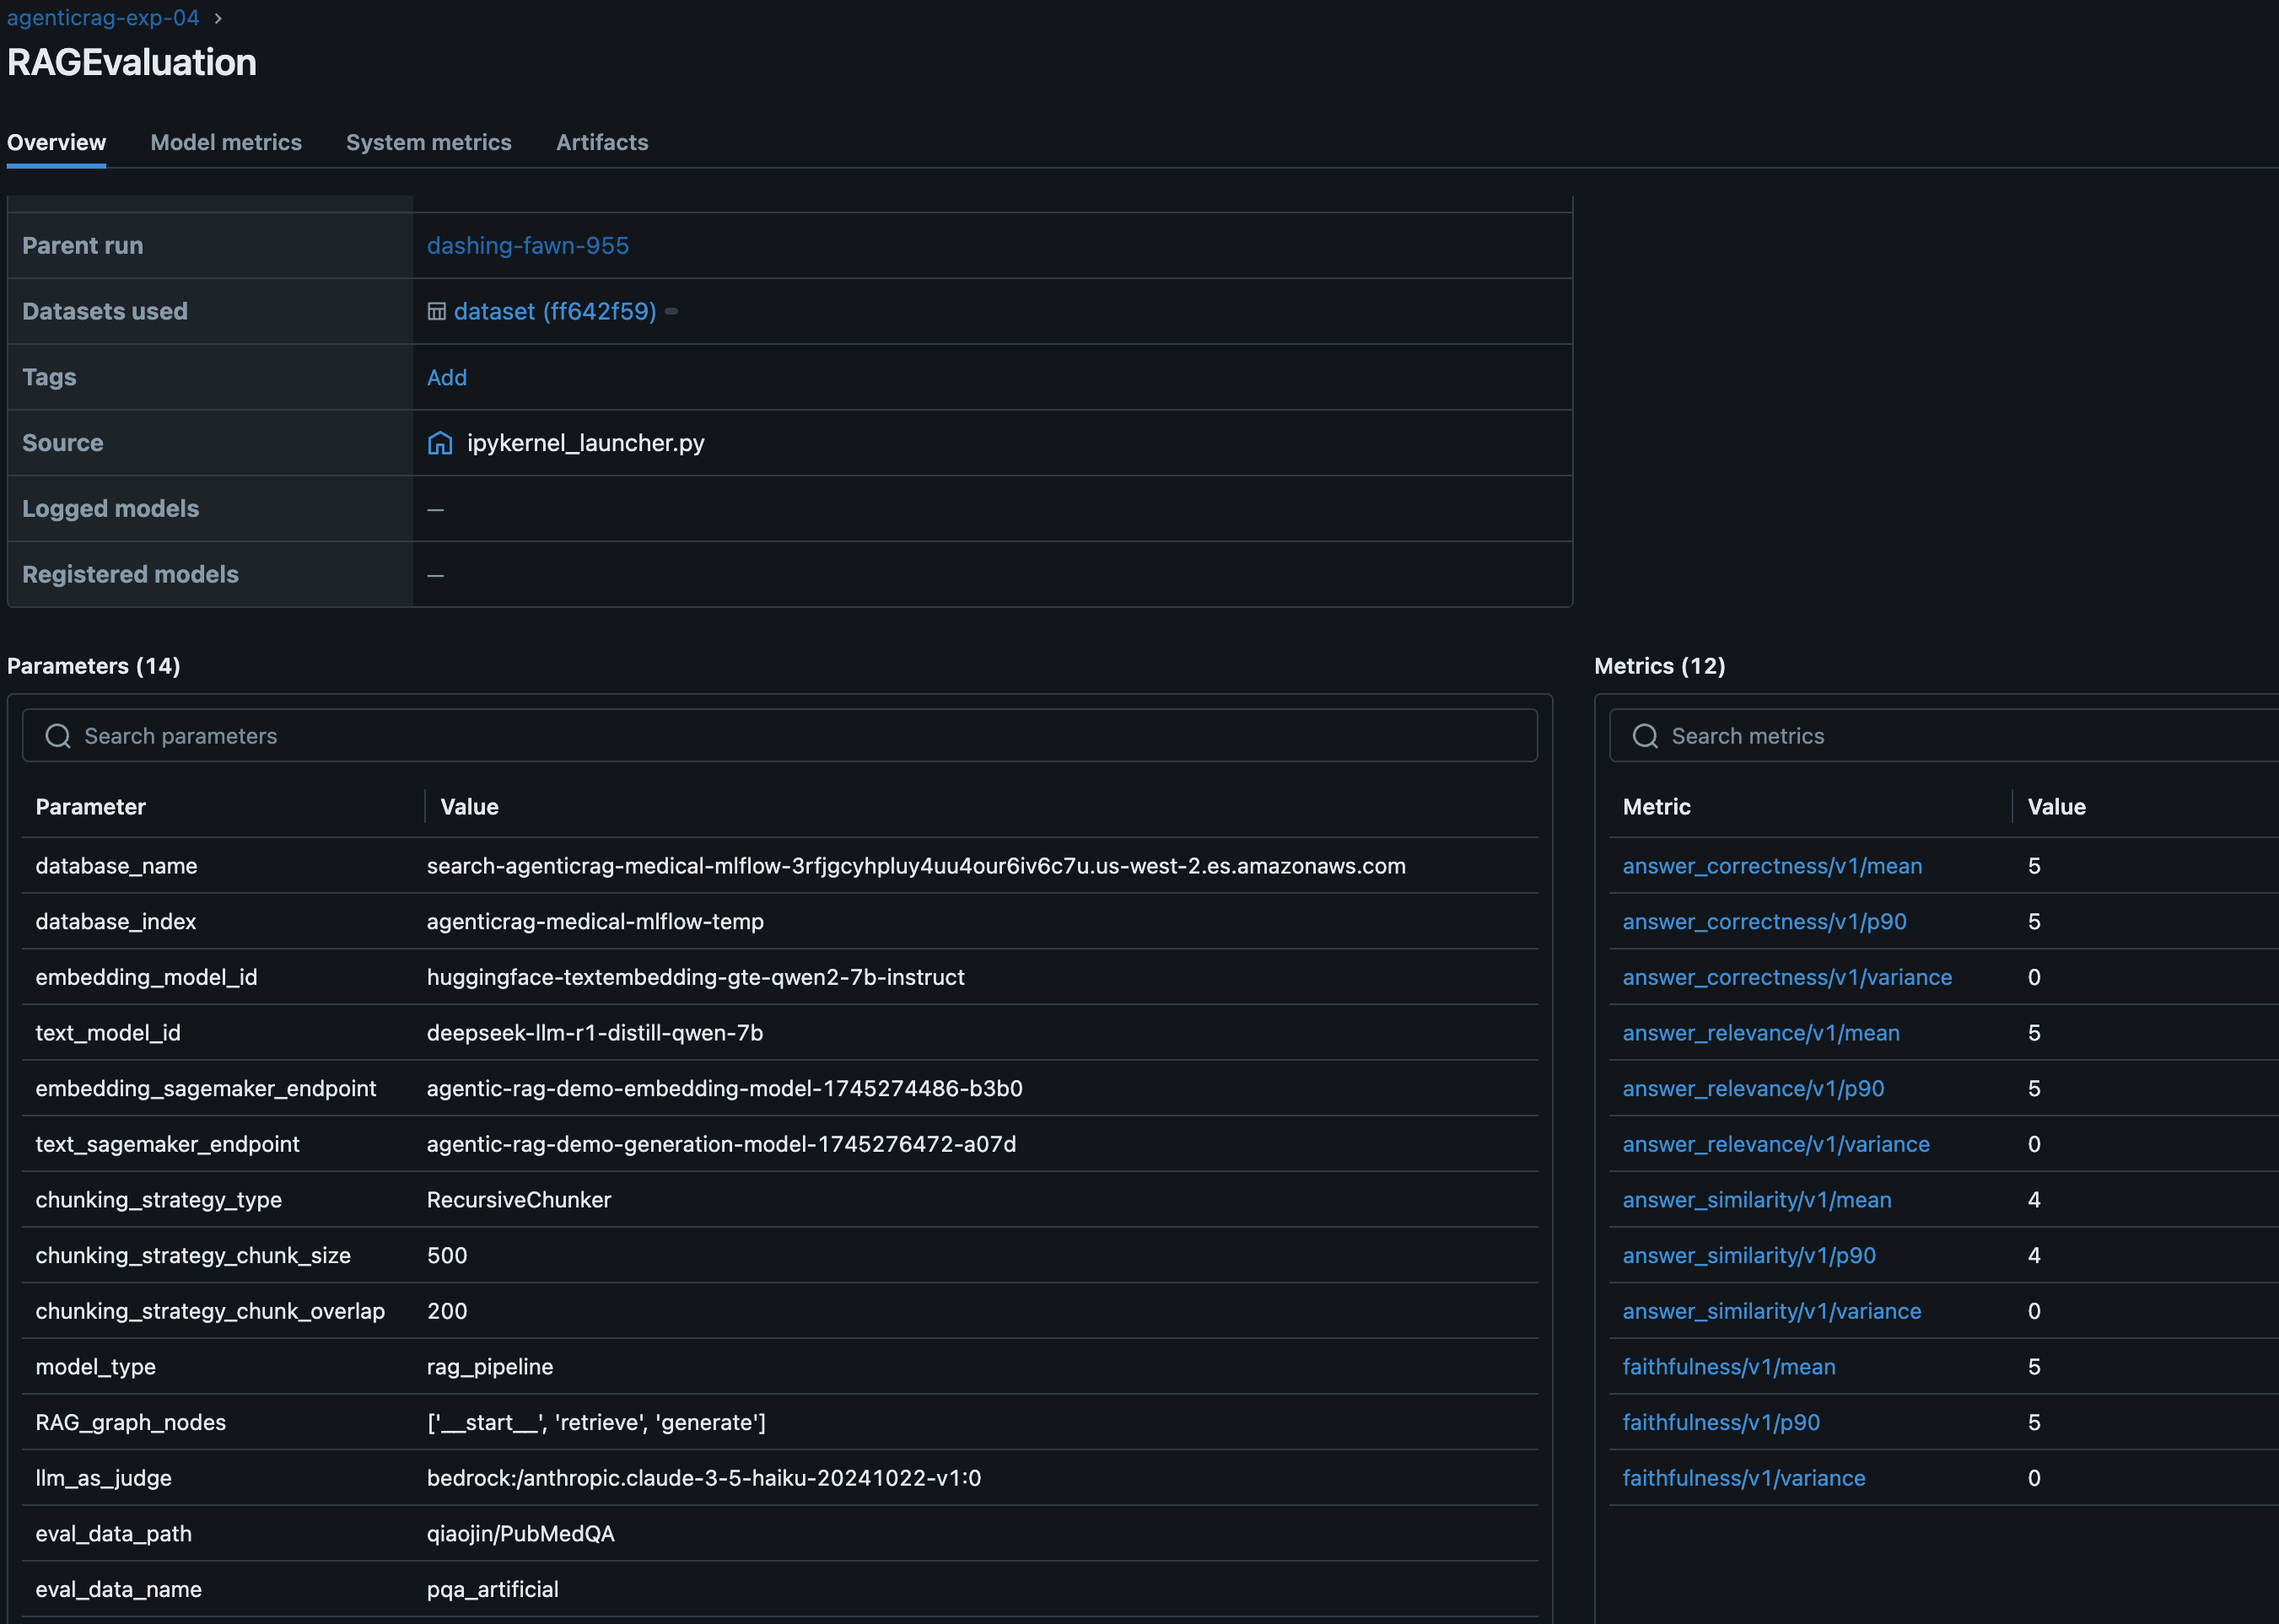

## RAGAS metrics (Coming Soon!)
https://github.com/aws-samples/genai-ml-platform-examples/blob/main/operations/sagemaker-mlflow-trace-evaluate-langgraph-agent/additional_evaluations_with_ragas.ipynb

# Compare RAG pipeline experiments
Analyze and compare the performance of your RAG pipeline for different iteration of experiments. For example here, using two different chunking strategies: FixedSizeChunker and RecursiveChunker as seperate MLFlow experiments will help you understand the impact of chunking strategy on RAG effectiveness by visually and numerically comparing evaluation results.

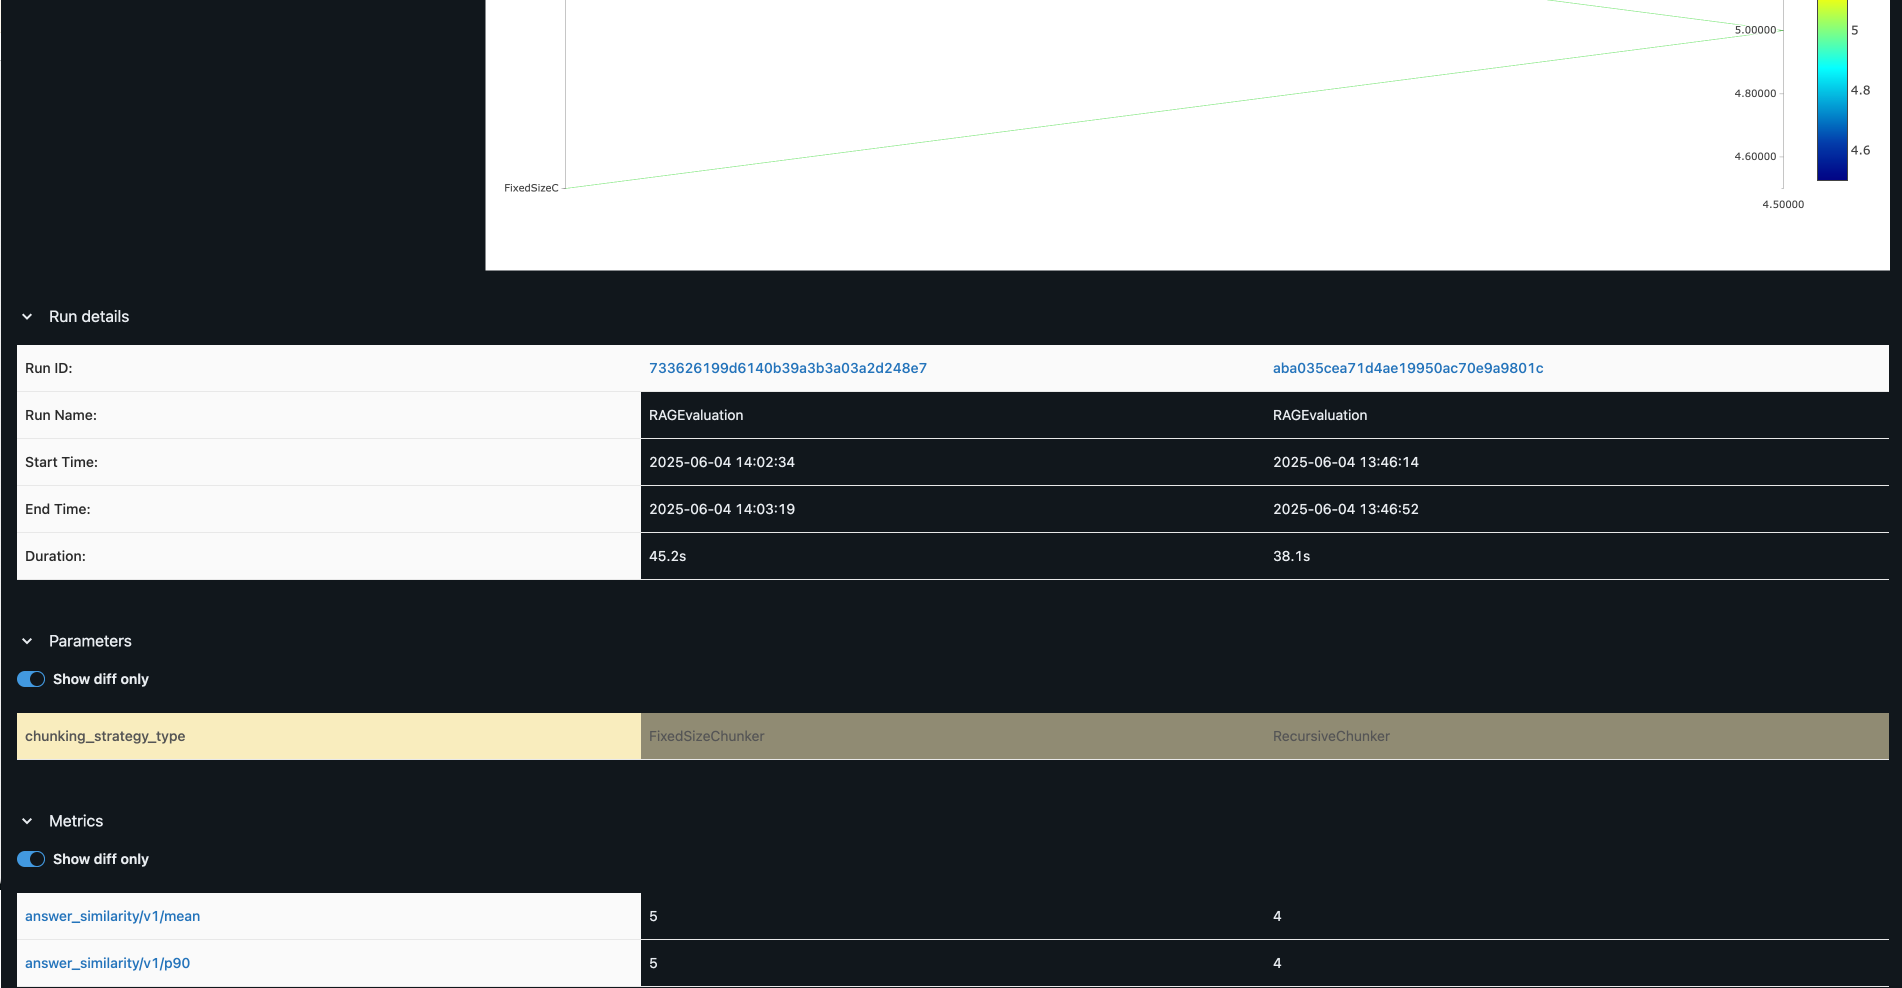

# Next Steps
Based on your comparison, decide whether to adopt the better-performing chunking strategy or continue experimenting with other parameters to further improve your RAG pipeline.
- Track all Key Findings in Sagemaker MLFlow: Document which chunking strategy performed better and by how much.
- Hypothesize Reasoning and collaboration: Consider why one strategy might outperform the other (e.g., better handling of document boundaries, more coherent chunks).
- Make Iterative Improvements by adjust Chunking Parameters: If the difference is significant, consider further tuning the chunk size and overlap for the better-performing strategy. 
- Experiment with differenct vector databases like Graph database with Amazon Neptune to fine-tune RAG pipeline performace. 
- Retest and Validate: Run additional experiments with adjusted parameters to confirm your findings and optimize the pipeline.

Then, navigate to /sagemaker_pipeline to see how you can create an automated CI/CD pipeline for creating and evaluating your RAG pipeline.